<a href="https://colab.research.google.com/github/blacker32/llm_repo/blob/master/finance_senitment_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction with LSTM and Transformer Models

In [ ]:
import math
import time
import io
import numpy as np
import csv
import pandas as pd
import os
from datetime import datetime
import random
# visuals package
import matplotlib.pyplot as plt
import seaborn as sns
# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Torchtest package
import torchtext
from torchtext import datasets
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
#Sklearn package
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_recall_fscore_support, classification_report, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, TimeSeriesSplit

#Tensorflow - Keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Softmax, Multiply, Permute, Flatten, Activation, Input, Attention, Bidirectional
from tensorflow.keras.models import Model

#cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set torch seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the random seed for other libraries
random.seed(seed)
np.random.seed(seed)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn


## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Utils

In [ ]:
import yfinance as yf

def get_stock_data(symbol, start_date, end_date):
    try:
        # Fetch historical data from Yahoo Finance
        data = yf.download(symbol, start=start_date, end=end_date)
        return data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None




In [ ]:
def oversample(X,y, oversampling_ratio = 0.8, maj_class = 2, min_class = (1,2)):
  oversampling_ratio = oversampling_ratio

  # Compute the number of synthetic samples to be generated based on the desired ratio and the size of the minority class
  max_class_count = np.sum(y == maj_class)
  print(max_class_count)
  desired_samples = int(max_class_count * oversampling_ratio)

  smote = SMOTE(sampling_strategy={i: desired_samples for i in min_class})
 # smote = SMOTE(sampling_strategy={min_class[i]: desired_samples[i] for i in min})

  # Step 4: Apply SMOTE to the minority class

  X_resampled, y_resampled = smote.fit_resample(X, y)

  # Step 5: (Optional) Check the class distribution
  unique, counts = np.unique(y_resampled, return_counts=True)
  print("Resampled class distribution",dict(zip(unique, counts)))
  return X_resampled, y_resampled

In [ ]:
def new_chg(data_chg):
  data_chg = data_chg.str.rstrip('%')
  data_chg = data_chg.astype(float)
  data_chg.fillna(0, inplace = True)
  return data_chg

def new_net(data_nett):
  data_nett.fillna(0, inplace = False)
  return data_nett

def obj_to_float(col):
  col = col.replace(',', '', regex=True)
  col = col.astype(float)
  return col

def new_date(data_date):
  data_date = data_date.replace("-","/")
  data_date = pd.to_datetime(data_date)
  return data_date

def new_time(data_time):
  data_time  = pd.to_datetime(data_time.astype(str),format = "%H:%M").dt.time
  return data_time


In [ ]:
def remove_redundant():
  start_time = datetime.strptime("22:02", '%H:%M').time()
  end_time = datetime.strptime("15:29", '%H:%M').time()

  return data[(data['Local Time'] < start_time) & (data['Local Time'] > end_time)]


In [ ]:
def build_target(column):
  target = []
  for change in column:
    if change >= 0.5 * column.std() :
      target.append(2)
    elif change <= -0.5 * column.std() :
      target.append(1)
    else:
      target.append(0)
  return target

def build_target_bin(column):
  target = np.where(column >= 0)
  return target

In [ ]:
def define_class_weights(data):
  grows, decrease, same = 0,0,0
  for value in data:
    if value == 2:
      grows += 1
    elif value == 1:
      decrease += 1
    else:
      same += 1
  class_labels = ["Hold",'Sell', 'Buy']
  plt.pie([same,decrease,grows], autopct='%1.1f%%' , labels=class_labels)
  plt.title("Class Distribution")
  plt.legend()
  n = len(tgt)
  class_weight = [same/n, decrease/n, grows/n]
  weight_tensor = loss_weights_light_keras(class_weight)
  for i , val in enumerate(weight_tensor) :
    print("class",i,"is weighted",val)
  return weight_tensor

In [ ]:
# Calculate Williams %R
def calculate_williams_percent_r(high, low, close, period):
    highest_high = high.rolling(window=period).max()
    lowest_low = low.rolling(window=period).min()
    williams_percent_r = (highest_high - close) / (highest_high - lowest_low) * -100
    return williams_percent_r

def calculate_rsi(data, window):
    close_prices = data['Close']
    delta = close_prices.diff().dropna()
    # Calculate gains and losses
    gains = delta.copy()
    losses = delta.copy()
    gains[gains < 0] = 0
    losses[losses > 0] = 0
    # Calculate average gains and losses
    avg_gains = gains.rolling(window).mean()
    avg_losses = losses.rolling(window).mean()
    # Calculate relative strength (RS)
    rs = abs(avg_gains / avg_losses)
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_ema(data, window):
    close_prices = data['Close']
    ema = close_prices.ewm(span=window, adjust=False).mean()
    return ema

In [ ]:
def normalize(x):
    x = (x - x.min(axis = 0))/(x.max(axis = 0) - x.min(axis = 0))
    return x


In [ ]:
from sklearn.model_selection import train_test_split
def train_test_split_fun(x,y,size = 0.1, stratify = True):
  if stratify:
    #y_train_encoded = pd.get_dummies(y)
    strat = y
  x_train, X_test, Y_train, y_test = train_test_split(x,y, train_size=size, stratify = strat )
  test = np.hstack((X_test,y_test))
  # Now since we want the valid and test size to be equal (10% each of overall data).
  # we have to define valid_size=0.5 (that is 50% of remaining data)
  X_train, X_valid, y_train, y_valid = train_test_split(x_train,Y_train, test_size= size, stratify = strat )
  train = np.hstack((X_train, y_train))
  valid = np.hstack((X_valid, y_valid))
  return train, valid, test

In [ ]:
def train_val_test(data,size):
  train_size = int(len(data)*size)
  test_coef = 0.5 #fraction of the remaining dataset to retain for the test set
  val_size = int((len(data) - train_size)*test_coef) + train_size
  train, val, test = data[:train_size, :], data[train_size:val_size, :], data[val_size:, : ]
  return train, val, test

def train_val_test_k(data,size,val_coef = 0.5):
  train_size = int(len(data)*size)
  coef = val_coef #fraction of the remaining dataset to retain for the test set
  val_size = int((len(data) - train_size)*coef) + train_size
  train, val, test = data.iloc[:train_size, :], data.iloc[train_size:val_size, :], data.iloc[val_size:, : ]
  return train, val, test



In [ ]:
def generate_dataset(data, lookback):
  """ This function is used to convert a timeseries dataset into a  prediction dataset
    Arguments:
              data: time series set
              lookback: time window length for predicions
"""
  x, y = [], []
  for i in range(len(data)-lookback):
    features = data[i:i+lookback, :-1]
    target = data[i+lookback, -1]
    x.append(features)
    y.append(target)
  return torch.tensor(np.array(x)),torch.tensor(np.array(y))

def generate_keras_dataset(data, lookback):
  """ This function is used to convert a timeseries dataset into a  prediction dataset
    Arguments:
              data: time series set
              lookback: time window length for predicions
"""
  x, y = [], []
  for i in range(len(data)-lookback):
    features = data.iloc[i:i+lookback, :-1]
    target = data.iloc[i+lookback, -1]
    x.append(features)
    y.append(target)
  return np.array(x),np.array(y)

In [ ]:
def boxplot(data):
  column_names = data.columns.tolist()
  data = data.values.astype("float64")
  fig, axes = plt.subplots(nrows=1, ncols=data.shape[1], figsize=(18, 8))

# Iterate over each feature and create a boxplot
  for i, ax in enumerate(axes):
      ax.boxplot(data[:, i])
      ax.set_xlabel('Feature {}'.format(i+1))
      ax.set_ylabel('Dollars')
      ax.set_title('Boxplot of {}'.format(column_names[i]))
  plt.tight_layout()

  # Display the plot
  plt.show()

In [ ]:
def loss_weights(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = torch.tensor(majority_class/np.array(weights))
  w = w + (w != 1.0).float()
  w = torch.ceil(w)
  return w

def loss_weights_light(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = torch.tensor(majority_class/np.array(weights))
  w = w - (w != 1.0).float()
  return w


def loss_weights_keras(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = np.array(majority_class/np.array(weights))
  #w = w + (w != 1.0).float()
  w = np.ceil(w)
  return w

def loss_weights_light_keras(weights):
  """ weights is a list with the precentage of each class in the dataset
  returns the tensor used in to weight the loss function"""
  majority_class = max(weights)
  w = np.array(majority_class/np.array(weights))
  return w

## Model Implementation

#### LSTM


 The following equations describe LSTM 's architecture:
\begin{array}{ll} \\
    i_t = \sigma(x_t.W_{ii}  + b_{ii} +  h_{t-1}.W_{hi} + b_{hi}) \\
    f_t = \sigma(x_t.W_{if} + b_{if} +  h_{t-1}.W_{hf} + b_{hf}) \\
    g_t = \tanh(x_t.W_{ig} + b_{ig} +  h_{t-1}.W_{hg} + b_{hg}) \\
    o_t = \sigma( x_t.W_{io} + b_{io} +  h_{t-1}.W_{ho} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}

However, thanks to nn.Module, all this is already implemented by simply importing the library.

In [ ]:
from tensorflow.keras.regularizers import l2

def create_keras_model(inp_size=2, hidden_size=64, output_size=3, dropout_rate=0.1, num_layers=5,l2_rate = 0.01):
    model = Sequential()
    for _ in range(num_layers - 2):
        model.add(LSTM(hidden_size, input_shape=(None, inp_size), return_sequences=True, kernel_regularizer=l2(l2_rate)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(hidden_size, return_sequences=False, kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32,activation = "relu", kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(0.2))

    model.add(Dense(output_size, kernel_regularizer=l2(l2_rate)))
    model.add(Softmax(axis=-1))

    return model

#### AttentionLSTM

In [ ]:
def build_attention_model(input_shape, hidden_size, num_layers, dropout_rate, l2_rate):
    inputs = Input(shape=input_shape)
    lstm_out, forward_h, backward_h, forward_c, backward_c = Bidirectional(
        LSTM(hidden_size, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_rate))
    )(inputs)

    lstm_out = Dropout(dropout_rate)(lstm_out)

    for _ in range(num_layers - 1):
        # LSTM layer
        lstm_out, forward_h, backward_h, forward_c, backward_c = Bidirectional(
            LSTM(hidden_size, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_rate))
        )(lstm_out)
        #lstm_out = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True))(lstm_out)
        lstm_out = Dropout(dropout_rate)(lstm_out)

    # Attention layer
    attention = Attention()([lstm_out, lstm_out])

    # Flatten layer to prepare the output of the attention layer for the Dense layer
    flat = Flatten()(attention)

    # Dense (output) layer
    outputs = Dense(3, activation='softmax', kernel_regularizer=l2(l2_rate))(flat)

    att_model = Model(inputs=inputs, outputs=outputs)
    return att_model

#### Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0,l2_rate = 0.05):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", kernel_regularizer=l2(l2_rate))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, kernel_regularizer=l2(l2_rate))(x)
    return x + res


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    l2_rate = 0.05
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_rate)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# APPLE day analysis

### Read the data

In [ ]:
if __name__ == "__main__":
    # Set the stock symbol, start date, and end date
    stock_symbol = "AAPL"  # Replace with the desired stock symbol
    start_date = "1999-12-31"  # Replace with the desired start date (YYYY-MM-DD format)
    end_date = "2023-07-23"  # Replace with the desired end date (YYYY-MM-DD format)

    # Get the stock data
    data = get_stock_data(stock_symbol, start_date, end_date)
    data.sort_index(ascending=True, inplace=True)
    if data is not None:
      data["Date"] = data.index
      data['Net'] = data['Close'].diff()
      data["Net"].fillna(0.0, inplace=True)
      data = data.drop(['Adj Close'], axis=1)

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Date,Net
Date,,,,,,,
1999-12-31,0.901228,0.918527,0.888393,0.917969,163811200,1999-12-31,0.000000
2000-01-03,0.936384,1.004464,0.907924,0.999442,535796800,2000-01-03,0.081473
2000-01-04,0.966518,0.987723,0.903460,0.915179,512377600,2000-01-04,-0.084263
2000-01-05,0.926339,0.987165,0.919643,0.928571,778321600,2000-01-05,0.013392
2000-01-06,0.947545,0.955357,0.848214,0.848214,767972800,2000-01-06,-0.080357
...,...,...,...,...,...,...,...
2023-07-17,191.899994,194.320007,191.809998,193.990005,50520200,2023-07-17,3.300003
2023-07-18,193.350006,194.330002,192.419998,193.729996,48353800,2023-07-18,-0.260010
2023-07-19,193.100006,198.229996,192.649994,195.100006,80507300,2023-07-19,1.370010


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5926 entries, 1999-12-31 to 2023-07-21
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5926 non-null   float64       
 1   High    5926 non-null   float64       
 2   Low     5926 non-null   float64       
 3   Close   5926 non-null   float64       
 4   Volume  5926 non-null   int64         
 5   Date    5926 non-null   datetime64[ns]
 6   Net     5926 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 370.4 KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5926 entries, 1999-12-31 to 2023-07-21
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5926 non-null   float64       
 1   High    5926 non-null   float64       
 2   Low     5926 non-null   float64       
 3   Close   5926 non-null   float64       
 4   Volume  5926 non-null   int64         
 5   Date    5926 non-null   datetime64[ns]
 6   Net     5926 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 370.4 KB


###Data Preprocessing

Now I combine Date and Time into DateTime for graphic purposes.


Clean the data to have the correct field types and filling missing values.

In [ ]:
#data["%Chg"] = new_chg(data["%Chg"])
data["Volume"] = obj_to_float(data["Volume"])
#data['Exchange Date'] = new_date(data['Exchange Date'])
data['Date'] = new_date(data['Date'])


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5926 entries, 1999-12-31 to 2023-07-21
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5926 non-null   float64       
 1   High    5926 non-null   float64       
 2   Low     5926 non-null   float64       
 3   Close   5926 non-null   float64       
 4   Volume  5926 non-null   float64       
 5   Date    5926 non-null   datetime64[ns]
 6   Net     5926 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 370.4 KB


 We need to realize that there are too many datapoints because date and time do not account for hours in which the market is closed and prices do not move. Therefore, we need to remove redundant times.

In [ ]:

data.reset_index(drop=True, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5926 entries, 0 to 5925
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5926 non-null   float64       
 1   High    5926 non-null   float64       
 2   Low     5926 non-null   float64       
 3   Close   5926 non-null   float64       
 4   Volume  5926 non-null   float64       
 5   Date    5926 non-null   datetime64[ns]
 6   Net     5926 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 324.2 KB


In [ ]:
max_value = data['Volume'].max()
data['Volume'] = data['Volume'].replace(max_value, data['Volume'].where(data['Volume'] != max_value).max())

#### Feature Engineering

In [ ]:
period = 20


# Calculate standard deviation
data['std_dev'] = data['Close'].copy().rolling(window=period).std()

# Calculate Williams %R

data['williams_percent_r'] = calculate_williams_percent_r(data['High'], data['Low'], data['Close'], period)
# exponential moving average
data["EMA"] = calculate_ema(data,period)
# residual strength index
data["RSI"] = calculate_rsi(data,period)

# Calculate the 7-day and 30-day moving averages
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_30'] = data['Close'].rolling(window=30).mean()


# Calculate the Moving Average Convergence Divergence (MACD)
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
data['MACD'] = macd - signal


data.head()
data.fillna(data.mean(), inplace = True)


<ipython-input-29-7b061479685a>:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.mean(), inplace = True)


In [ ]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5926 entries, 0 to 5925
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Open                5926 non-null   float64       
 1   High                5926 non-null   float64       
 2   Low                 5926 non-null   float64       
 3   Close               5926 non-null   float64       
 4   Volume              5926 non-null   float64       
 5   Date                5926 non-null   datetime64[ns]
 6   Net                 5926 non-null   float64       
 7   std_dev             5926 non-null   float64       
 8   williams_percent_r  5926 non-null   float64       
 9   EMA                 5926 non-null   float64       
 10  RSI                 5926 non-null   float64       
 11  MA_7                5926 non-null   float64       
 12  MA_30               5926 non-null   float64       
 13  MACD                5926 non-null   float64     

### Create Target

#### Set the multi-class target. It consists in either a price stays the same (0) or decrease more than 0.5 std (1) or increase more than 0.5 std (2).

In [ ]:
data["Trend"] = build_target(data["Net"])

#### Target

In [ ]:
#data['Trend'] = np.where(data['Net'] < 0, 1, np.where(data['Net'] > 0, 2, 0))

([<matplotlib.axis.XTick at 0x7b6d27487ac0>,
 [Text(0.0, 0, '0'), Text(1.0, 0, '1'), Text(2.0, 0, '2')])

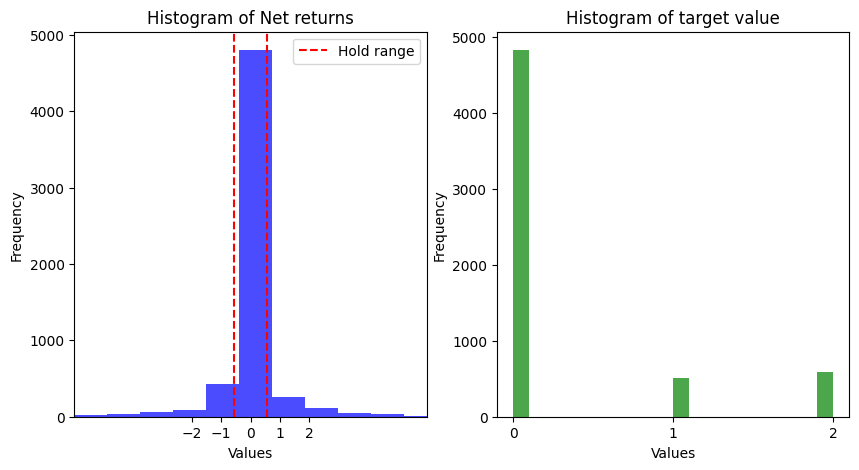

In [ ]:
plt.figure(figsize=(10, 5))

# Plot the first histogram on the left subplot
plt.subplot(1, 2, 1)
plt.hist(data["Net"], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Net returns')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(-6, 6)
plt.axvline(data["Net"].std()*0.5, color='r', linestyle='--', label='Hold range')
plt.axvline(- data["Net"].std()*0.5, color='r', linestyle='--')

# Calculate the number of ticks around zero
num_ticks = 5
# Set the tick positions and labels
ticks = np.linspace(-2, 2, num_ticks)
plt.xticks(ticks)
plt.legend()
# Plot the second histogram on the right subplot
plt.subplot(1, 2, 2)
plt.hist(data["Trend"], bins=20, color='green', alpha=0.7)
plt.title('Histogram of target value')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 2.1, 1)
)

class 0 is weighted 1.0
class 1 is weighted 11.0
class 2 is weighted 10.0


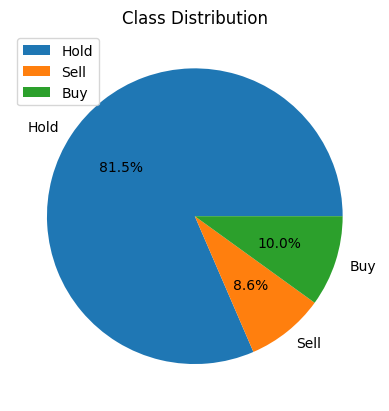

In [ ]:
tgt = data["Trend"]
grows, decrease, same = 0,0,0
for value in tgt:
  if value == 2:
    grows += 1
  elif value == 1:
    decrease += 1
  else:
    same += 1
class_labels = ["Hold",'Sell', 'Buy']
plt.pie([same,decrease,grows], autopct='%1.1f%%' , labels=class_labels)
plt.title("Class Distribution")
plt.legend()
n = len(tgt)
class_weight = [same/n, decrease/n, grows/n]
weight_tensor = loss_weights(class_weight)
for i , val in enumerate(weight_tensor.numpy()) :
  print("class",i,"is weighted",val)

### Feature Selection

In [ ]:
correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)

correlations

<ipython-input-36-ce59e57b9ad5>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)


Close                 0.639724
High                  0.638621
Low                   0.636447
EMA                   0.636386
MA_30                 0.636131
Open                  0.635641
MA_7                  0.635272
std_dev               0.603843
Net                   0.299023
MACD                  0.042880
williams_percent_r    0.041094
RSI                   0.005689
Volume               -0.280831
dtype: float64

In [ ]:
correlation_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]


<ipython-input-37-5fbb337c4d5d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr().abs()
<ipython-input-37-5fbb337c4d5d>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


In [ ]:
print(to_drop)

['High', 'Low', 'Close', 'std_dev', 'EMA', 'RSI', 'MA_7', 'MA_30']


In [ ]:
from sklearn.feature_selection import mutual_info_classif
X = data[["Close","Volume", "Net","williams_percent_r","MACD",'std_dev', 'EMA', 'RSI', 'MA_7', 'MA_30']]
y = data["Trend"]
mi_scores = mutual_info_classif(X, y, random_state=0)

# Create a dataframe of features and their mutual information scores
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})

# Display the dataframe sorted by MI_Score in descending order
mi_scores_df.sort_values('MI_Score', ascending=False)

,Feature,MI_Score
2,Net,0.606661
0,Close,0.242407
8,MA_7,0.237718
9,MA_30,0.237693
5,std_dev,0.237203
6,EMA,0.231913
4,MACD,0.182416
1,Volume,0.098808
3,williams_percent_r,0.044197
7,RSI,0.009619


In [ ]:
columns = mi_scores_df["Feature"].iloc[np.where(mi_scores_df["MI_Score"] > 0.01)].tolist()
columns.append("Trend")
print(columns)

['Close', 'Volume', 'Net', 'williams_percent_r', 'MACD', 'std_dev', 'EMA', 'MA_7', 'MA_30', 'Trend']


### Some Visualizations

In [ ]:
df = data.rename(columns = {"Trend": "Investment Decision"})
correlation_matrix = df.corr()
correlation_matrix

<ipython-input-103-027f2ffe5bb9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,Open,High,Low,Close,Volume,Net,std_dev,williams_percent_r,EMA,RSI,MA_7,MA_30,MACD,Investment Decision
Open,1.000000,0.999847,0.999850,0.999673,-0.276157,0.004134,0.747705,0.026547,0.997786,0.012038,0.998892,0.993635,-0.010424,0.640347
High,0.999847,1.000000,0.999808,0.999857,-0.274810,0.013624,0.749602,0.028170,0.997800,0.012496,0.998843,0.993683,-0.009582,0.646412
Low,0.999850,0.999808,1.000000,0.999844,-0.277575,0.014505,0.744853,0.030132,0.997516,0.014628,0.998716,0.993278,-0.007750,0.641420
Close,0.999673,0.999857,0.999844,1.000000,-0.276016,0.024108,0.747167,0.031694,0.997546,0.014757,0.998662,0.993361,-0.007252,0.647182
Volume,-0.276157,-0.274810,-0.277575,-0.276016,1.000000,-0.027207,-0.158636,-0.032776,-0.273833,-0.024612,-0.274570,-0.274670,-0.014497,-0.106498
Net,0.004134,0.013624,0.014505,0.024108,-0.027207,1.000000,-0.031627,0.225252,-0.005774,0.136648,-0.004436,-0.007784,0.172727,0.276698
std_dev,0.747705,0.749602,0.744853,0.747167,-0.158636,-0.031627,1.000000,-0.042992,0.762975,-0.071461,0.752486,0.771381,-0.117647,0.558105
williams_percent_r,0.026547,0.028170,0.030132,0.031694,-0.032776,0.225252,-0.042992,1.000000,-0.004649,0.834843,0.013073,-0.020113,0.411294,0.070692
EMA,0.997786,0.997800,0.997516,0.997546,-0.273833,-0.005774,0.762975,-0.004649,1.000000,-0.019907,0.998762,0.997798,-0.056856,0.642011
RSI,0.012038,0.012496,0.014628,0.014757,-0.024612,0.136648,-0.071461,0.834843,-0.019907,1.000000,0.001330,-0.040253,0.327838,0.010017


<Axes: >

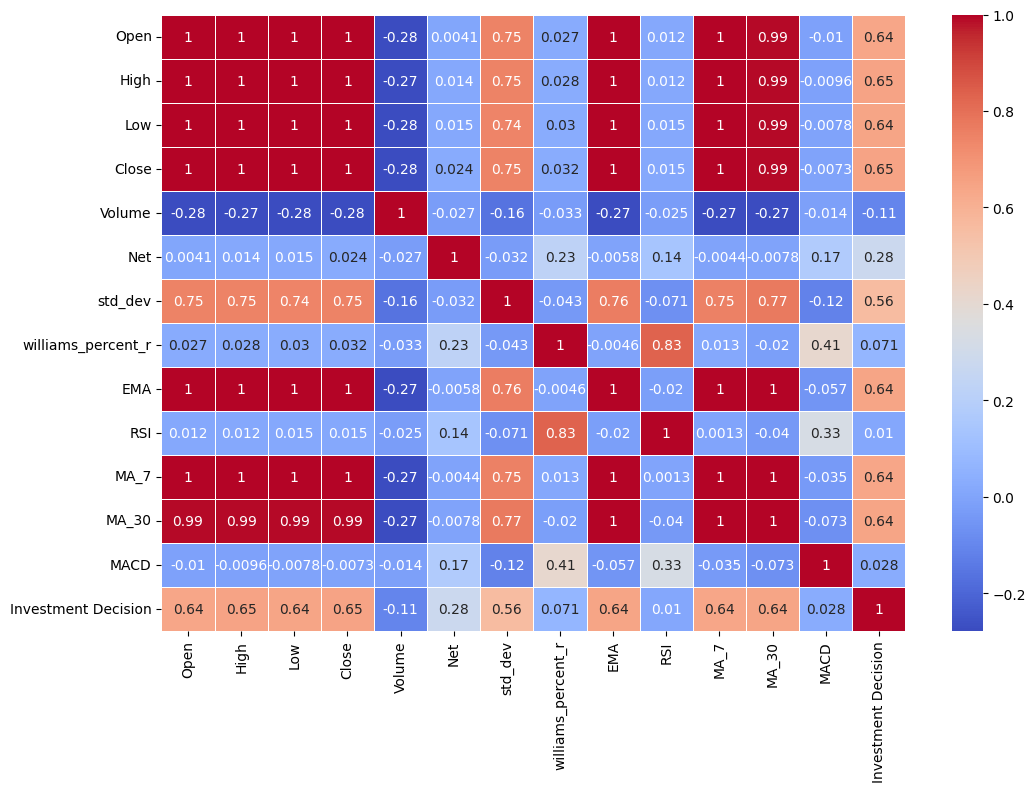

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(correlation_matrix, annot = True ,linewidths=0.5, cmap = "coolwarm")

#### Analyse closing prices

In [ ]:
data["Close"].describe()

count    5926.000000
mean       33.073073
std        47.291019
min         0.234286
25%         2.051428
50%        13.910714
75%        38.744376
max       195.100006
Name: Close, dtype: float64

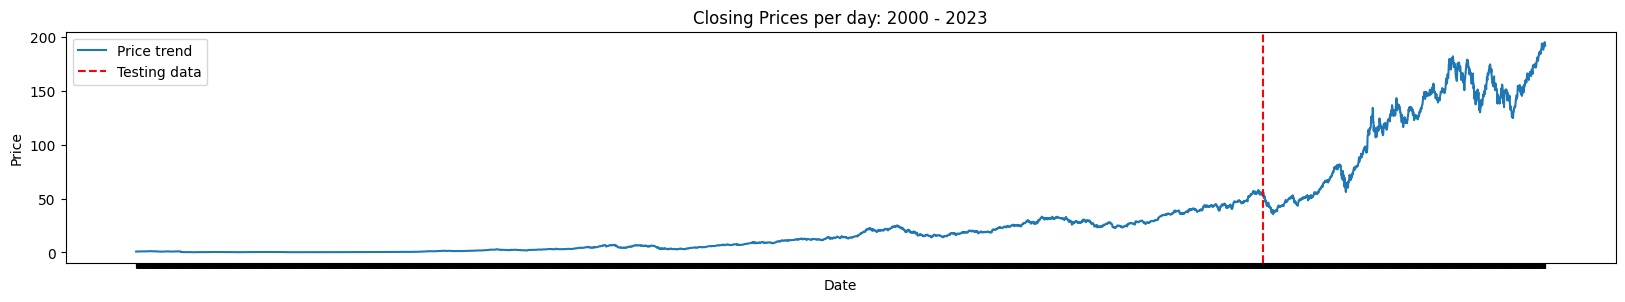

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data["Date"].astype(str), data["Close"])
plt.xlabel('Date')
plt.ylabel('Price')
# Remove tick labels
plt.gca().set_xticklabels([])
plt.axvline(int(len(data["Date"])*0.8), color='r', linestyle='--', label='Testing data')

plt.title('Closing Prices per day: 2000 - 2023')
plt.legend(["Price trend", 'Testing data'],fontsize="10")

Text(0.5, 1.0, 'Count of closing price values')

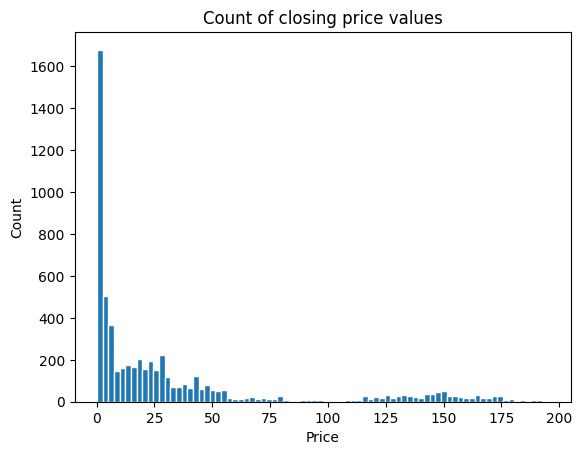

In [ ]:
plt.hist(data["Close"],edgecolor='white', bins = 80)
plt.ylabel("Count")
plt.xlabel("Price")
plt.title("Count of closing price values")

#### Volume

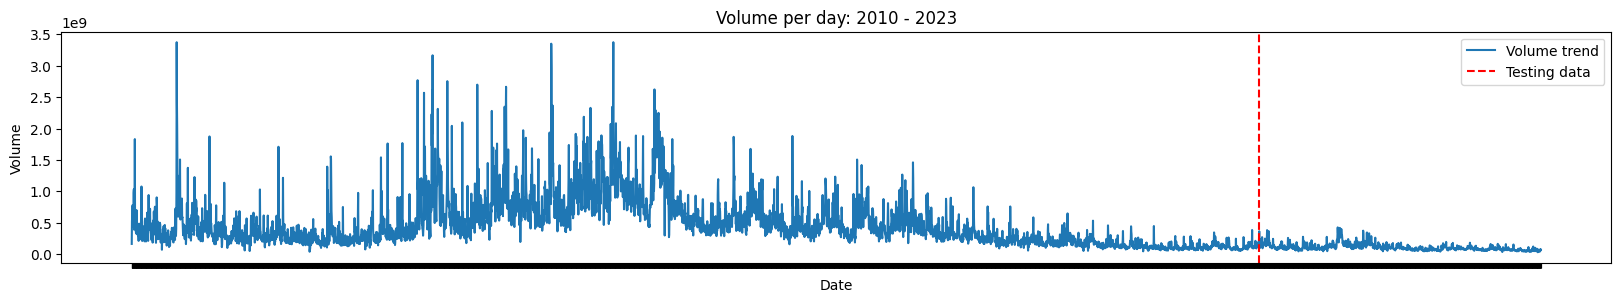

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data["Date"].astype(str), data["Volume"])
plt.xlabel('Date')
plt.ylabel('Volume')
# Remove tick labels
plt.gca().set_xticklabels([])
plt.axvline(int(len(data["Date"])*0.8), color='r', linestyle='--', label='Testing data')

plt.title('Volume per day: 2010 - 2023')
plt.legend(["Volume trend","Testing data" ],fontsize="10")

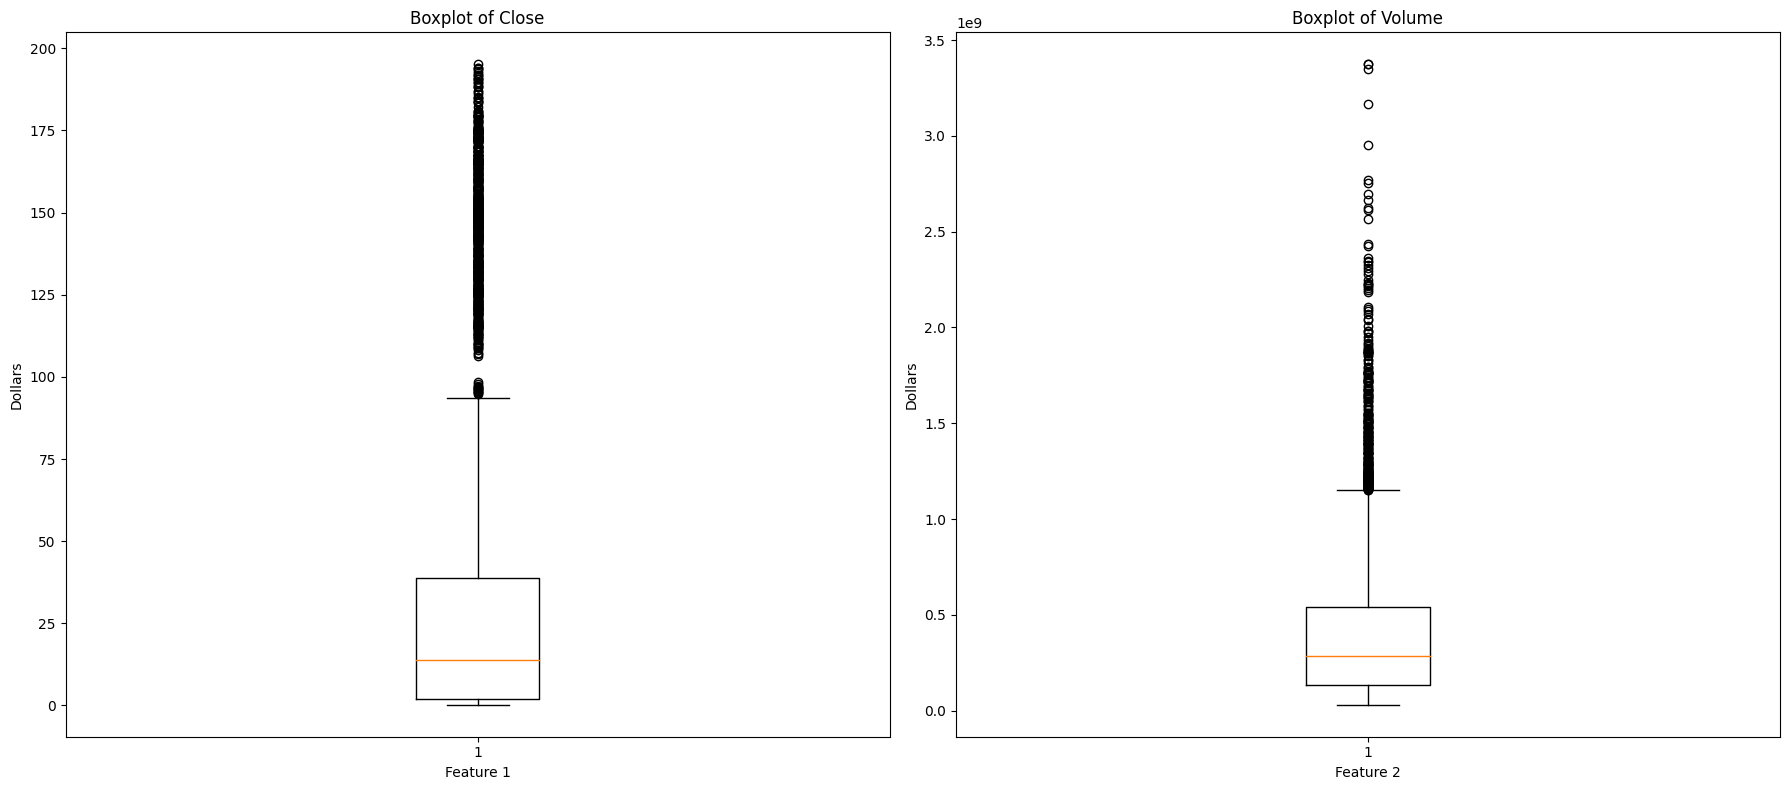

In [ ]:
X_viz = data[["Close", "Volume"]]
boxplot(X_viz)

It is clear that Volume shows exrteme outliers but they are crucial in identifying possible price trends as it represents the level of market activity and liquidity. Therefore, after dropping the very extreme outlier, all the rest is kept.

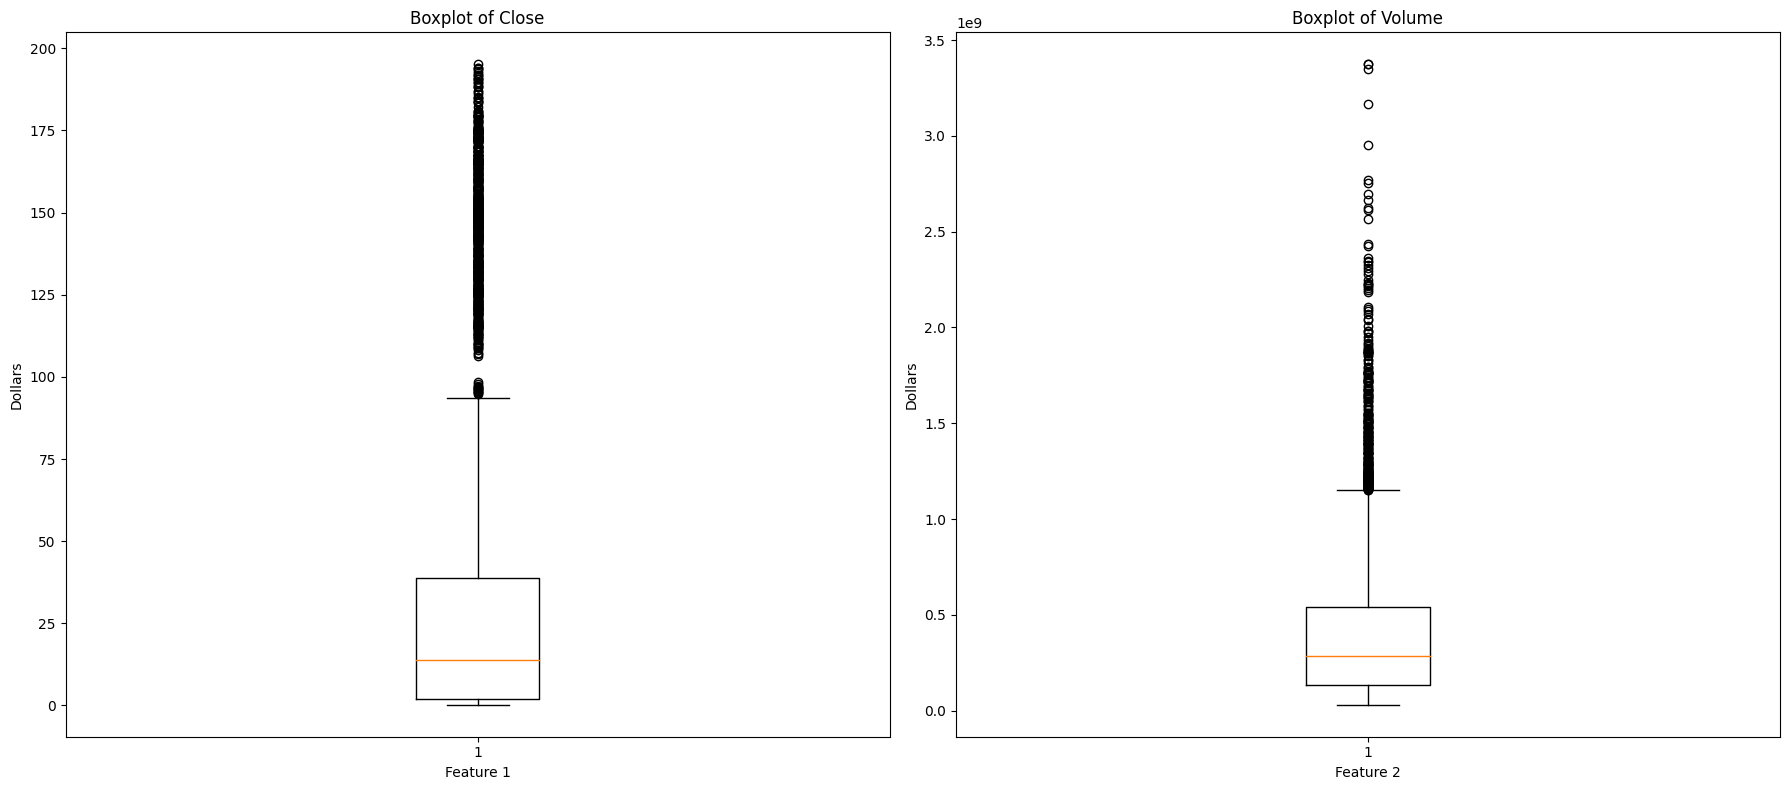

In [ ]:
X_new_vol = data[["Close", "Volume"]]
boxplot(X_new_vol)

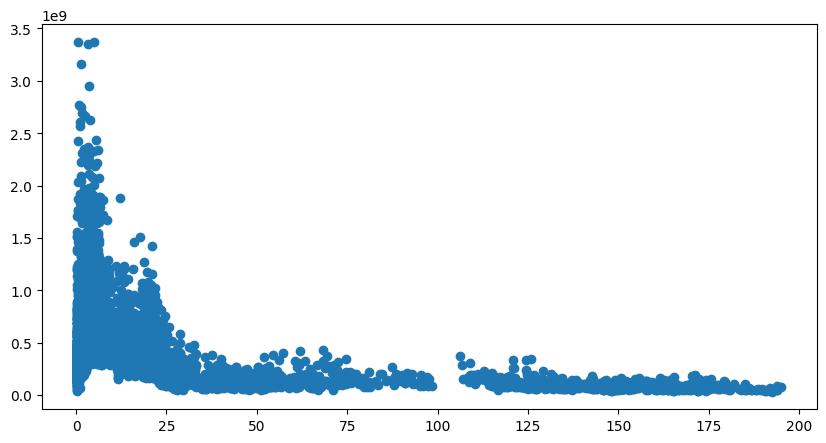

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(data["Close"],data["Volume"])

#### New Features

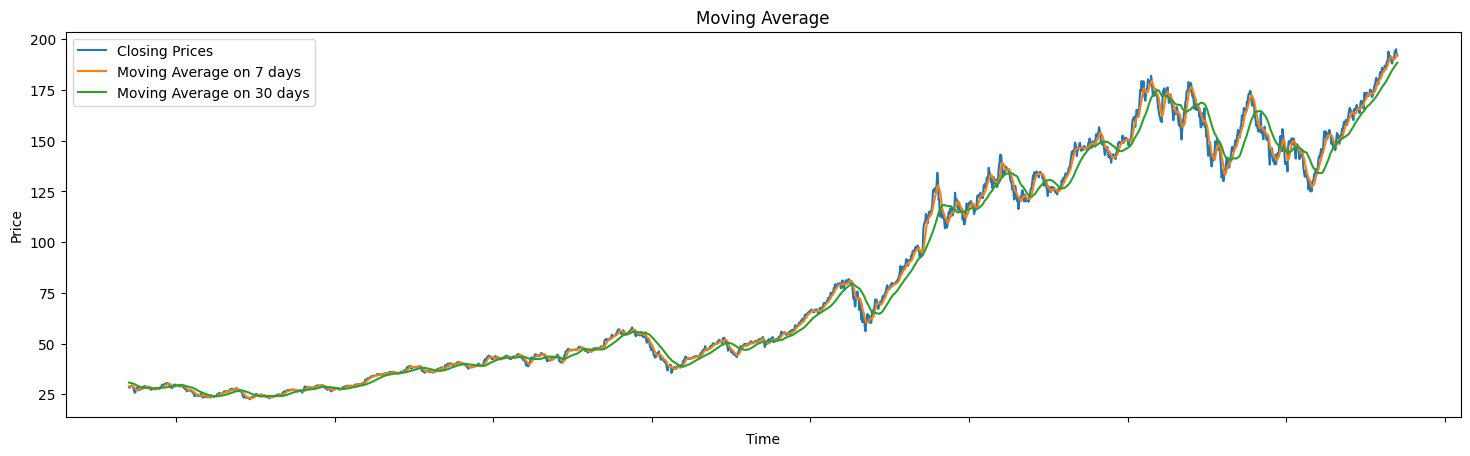

In [ ]:
##MA
plt.figure(figsize = (18,5))
plt.plot(data["Close"][-2000:], label='Closing Prices')
plt.plot(data["MA_7"][-2000:], label='Moving Average on 7 days')
plt.plot(data["MA_30"][-2000:], label='Moving Average on 30 days')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Moving Average')
plt.show()


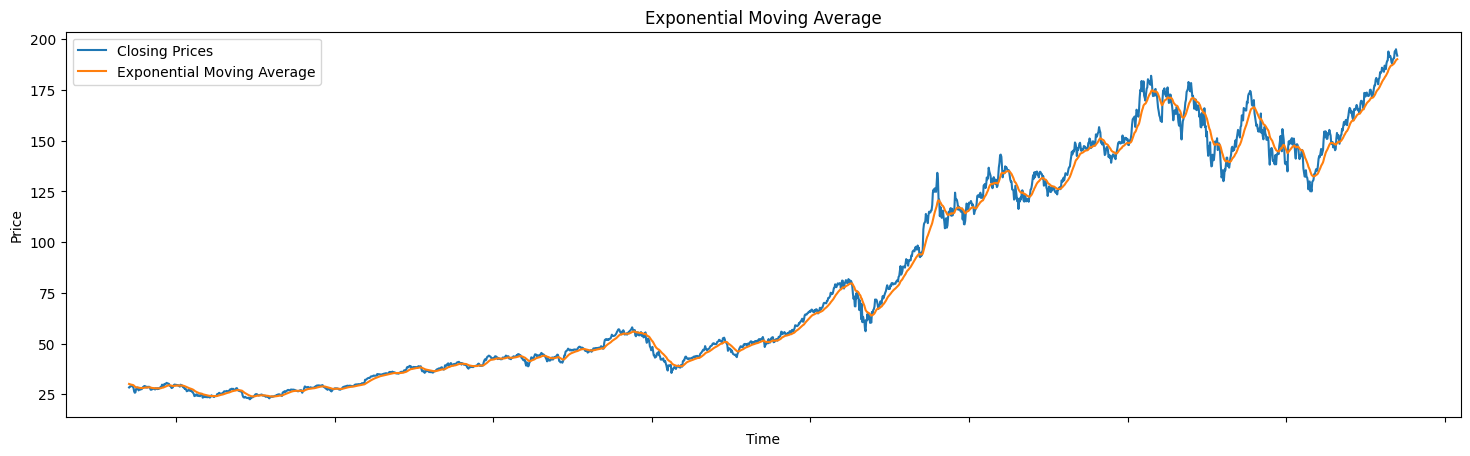

In [ ]:
##EMA
plt.figure(figsize = (18,5))
plt.plot(data["Close"][-2000:], label='Closing Prices')
plt.plot(data["EMA"][-2000:], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Exponential Moving Average')
plt.show()


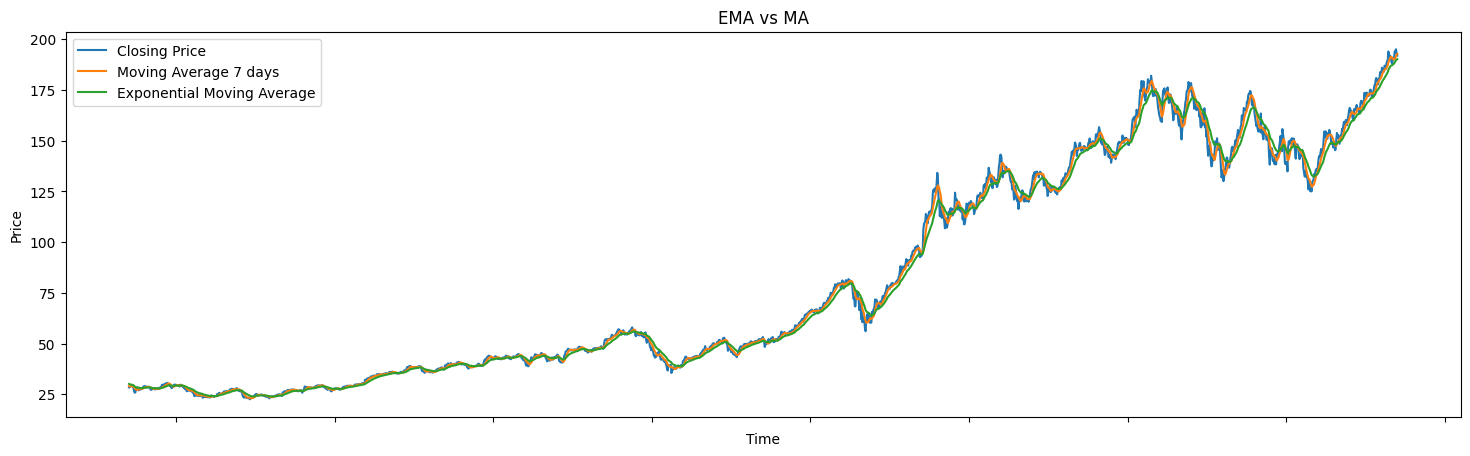

In [ ]:
##EMA vs MS
plt.figure(figsize = (18,5))
plt.plot(data["Close"][-2000:], label='Closing Price')
plt.plot(data["MA_7"][-2000:], label='Moving Average 7 days')
plt.plot(data["EMA"][-2000:], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('EMA vs MA')
plt.show()

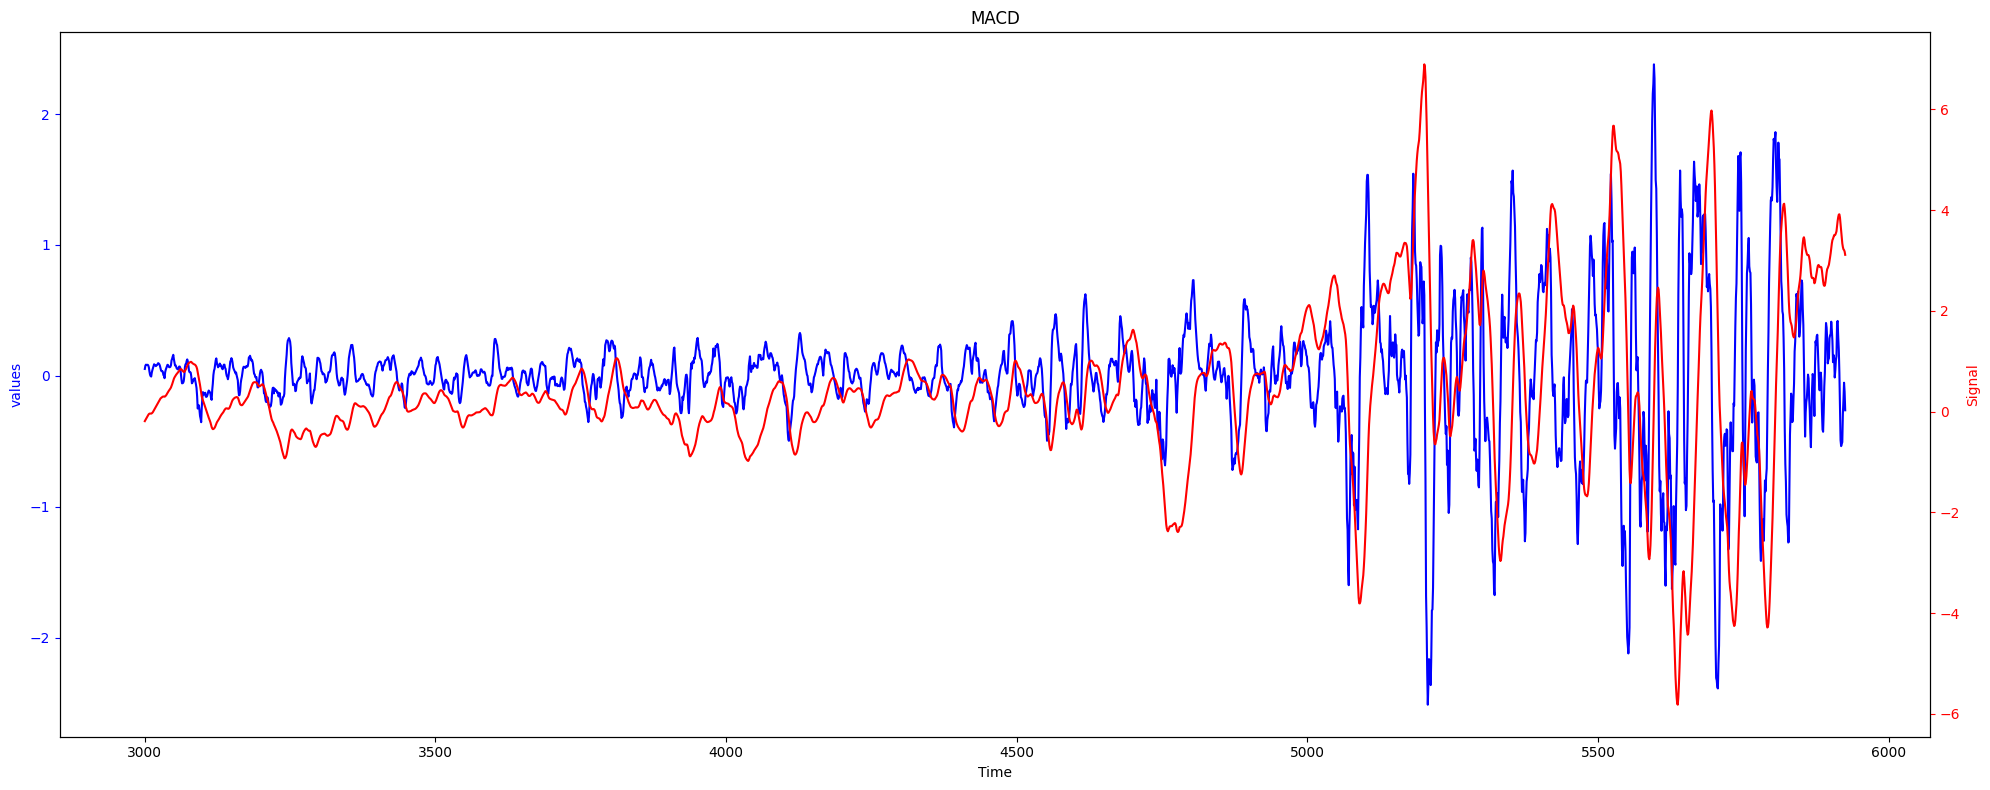

In [ ]:
## STD_DEV
fig, ax1 = plt.subplots(figsize = (20,8))

# Plot the closing prices on the primary y-axis
ax1.plot(data["MACD"][3000:], label='MACD line', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('values', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for the rolling standard deviation
ax2 = ax1.twinx()
ax2.plot(signal[3000:], label='Signal line', color='r')
ax2.set_ylabel('Signal', color='r')
ax2.tick_params('y', colors='r')

plt.title('MACD')
fig.tight_layout()
plt.show()

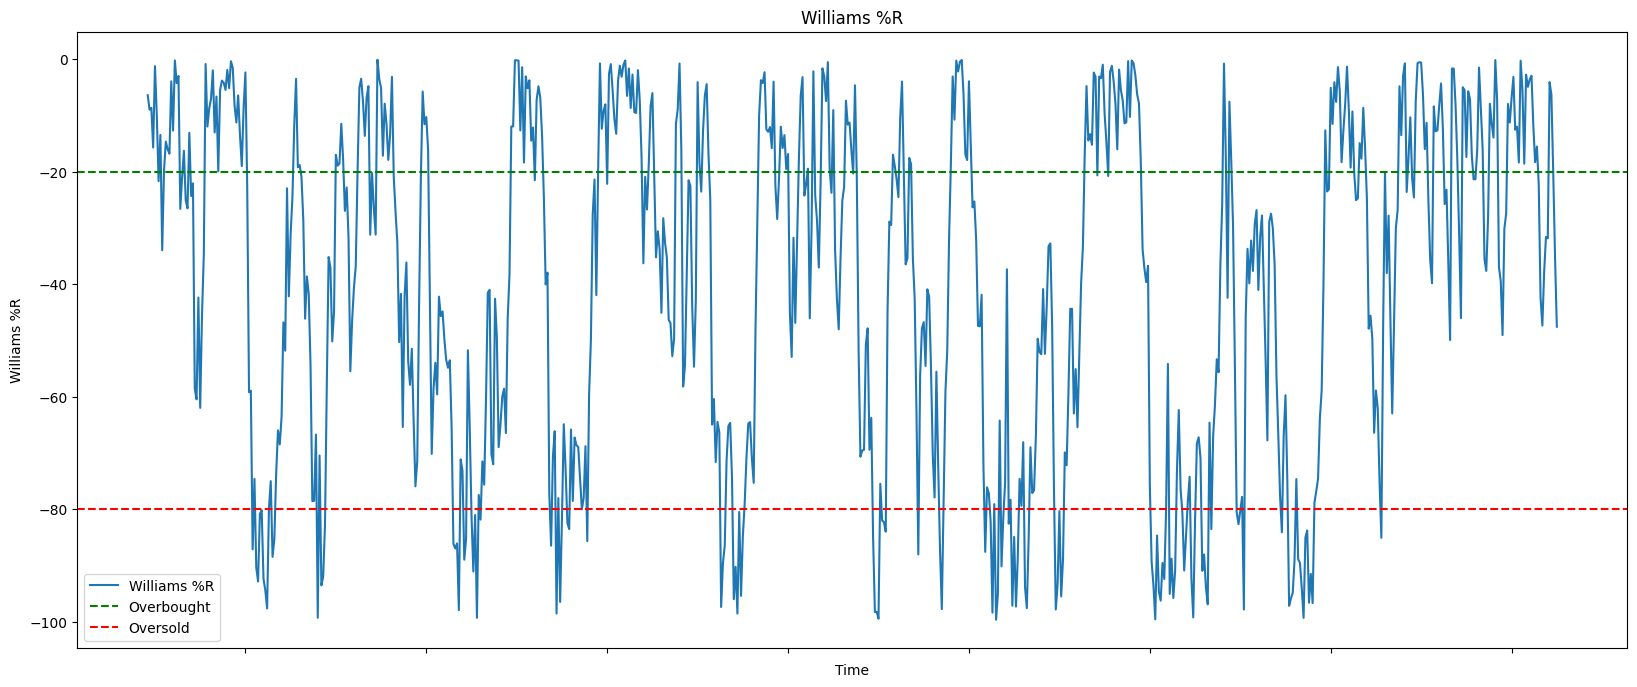

In [ ]:
## WILLIAMS %R
plt.figure(figsize = (20,8))
plt.plot(data["williams_percent_r"][-780:], label='Williams %R') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(-20, color='g', linestyle='--', label='Overbought')
plt.axhline(-80, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('Williams %R')
plt.title('Williams %R')
plt.show()

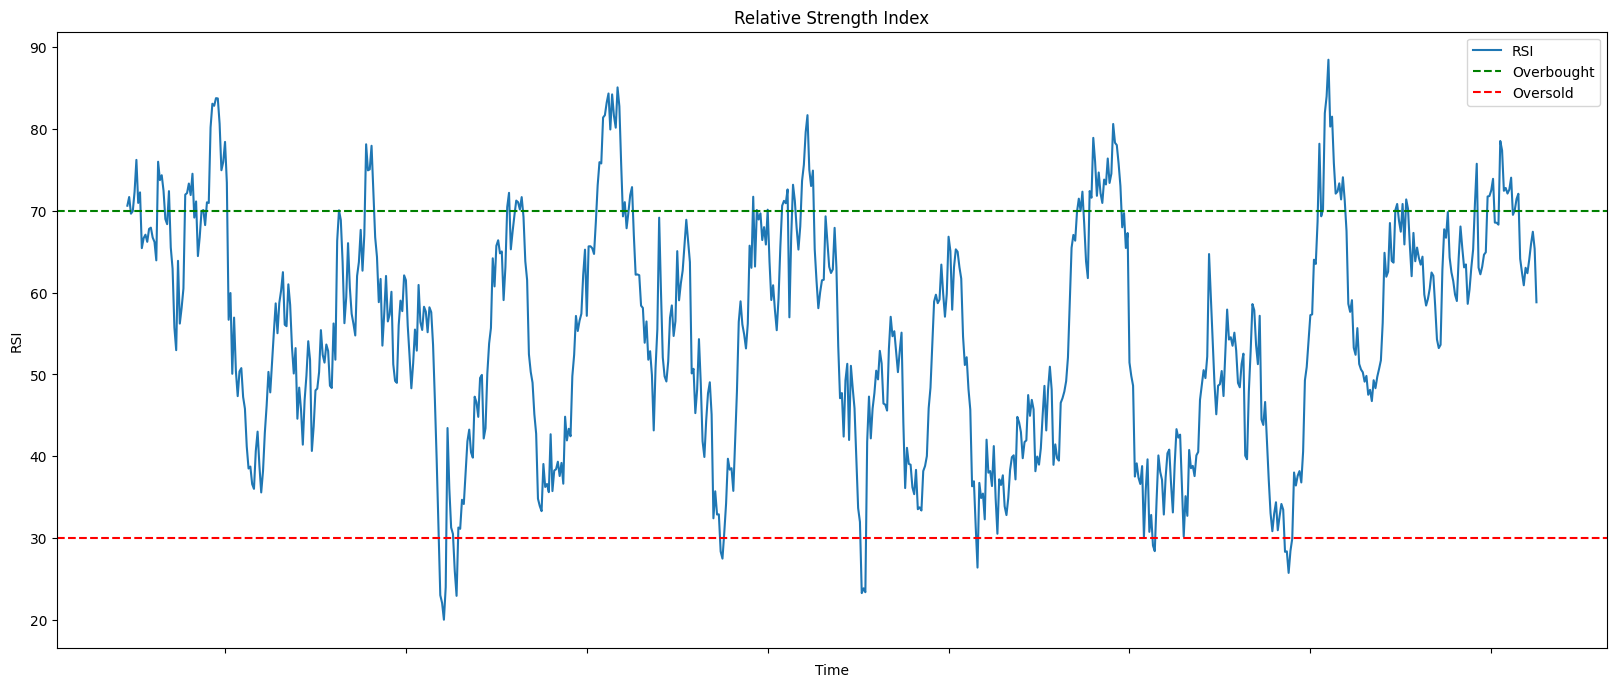

In [ ]:
##RSI
plt.figure(figsize = (20,8))
plt.plot(data["RSI"][-780:], label='RSI') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(70, color='g', linestyle='--', label='Overbought')
plt.axhline(30, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('RSI')
plt.title('Relative Strength Index')
plt.show()

### KERAS TRIAL

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

X_parent = data[columns].copy()
#train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.4)
train,  test = train_test_split(X_parent,test_size = 0.2)

X = train[columns[:-1]]  # All rows, all columns except the last one
y = train["Trend"]   # All rows, only the last column (class labels)
unique, counts = np.unique(y, return_counts=True)

initial_train_class = dict(zip(unique, counts))
print("Train class distribution", initial_train_class)


X_resampled, y_resampled = oversample(X,y,oversampling_ratio = 0.9, maj_class = 0)

train = pd.concat([X_resampled, y_resampled], axis=1)

Train class distribution {0: 3868, 1: 394, 2: 478}
3868
Resampled class distribution {0: 3868, 1: 3481, 2: 3481}


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
#valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns = columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
#valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 40)
#X_v, y_v = generate_keras_dataset(valid ,lookback = 40)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 40)

In [ ]:
print("X_Train shape is:", X_tr.shape)
#print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

X_Train shape is: (10790, 40, 9)
Testing set size is: (1146, 40, 9)


In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
#class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
#print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

Count of classes in the dataset {0: 4829, 1: 507, 2: 590}
Count of classes in the training set {0: 3834, 1: 3477, 2: 3479}
Count of classes in the test set {0: 926, 1: 110, 2: 110}


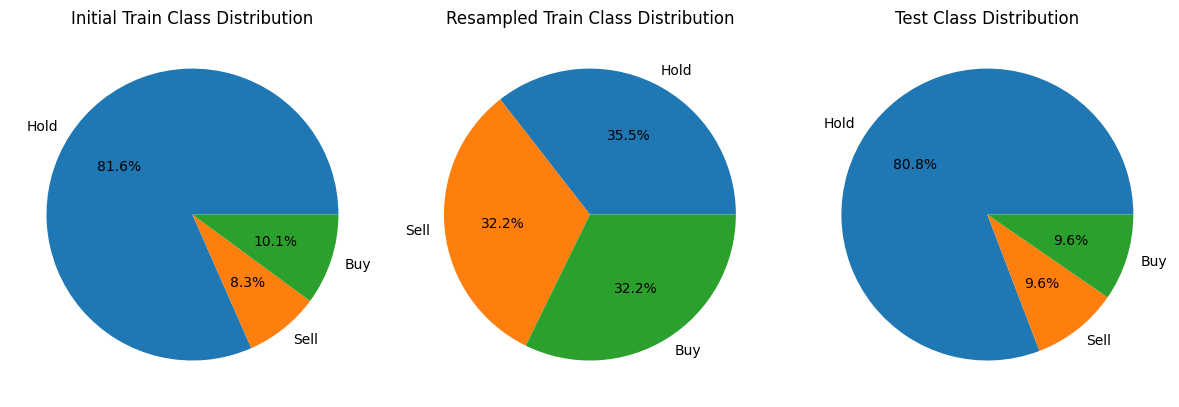

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 3, 1)
plt.pie(initial_train_class.values(), labels=labels, autopct='%1.1f%%')
plt.title("Initial Train Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 3, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title("Resampled Train Class Distribution")

# Plot the second pie chart in the middle subplot
#plt.subplot(1, 4, 3)
#plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
#plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 3, 3)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)


{0: 0.9380977221352809, 1: 1.0344166426996453, 2: 1.0338219794960237}


### KERAS TRIAL 2

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

X_parent = data[columns].copy()
#train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.4)
train,  test = train_test_split(X_parent,test_size = 0.2)

X = train[columns[:-1]]  # All rows, all columns except the last one
y = train["Trend"]   # All rows, only the last column (class labels)
unique, counts = np.unique(y, return_counts=True)

initial_train_class = dict(zip(unique, counts))
print("Train class distribution", initial_train_class)



Train class distribution {0: 3868, 1: 394, 2: 478}


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
#valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns = columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
#valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 40)
#X_v, y_v = generate_keras_dataset(valid ,lookback = 40)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 40)

In [ ]:
print("X_Train shape is:", X_tr.shape)
#print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

X_Train shape is: (4700, 40, 9)
Testing set size is: (1146, 40, 9)


In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
#class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
#print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

Count of classes in the dataset {0: 4829, 1: 507, 2: 590}
Count of classes in the training set {0: 3834, 1: 390, 2: 476}
Count of classes in the test set {0: 926, 1: 110, 2: 110}


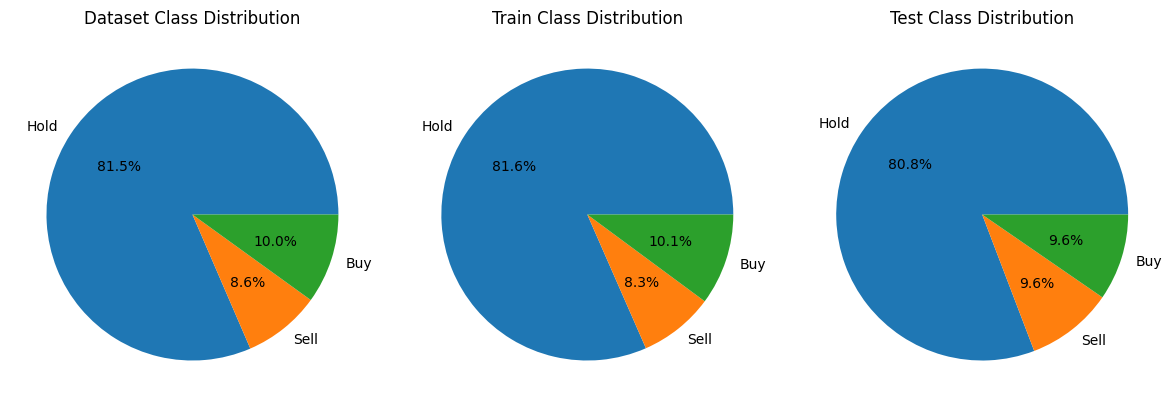

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 3, 1)
plt.pie(class_counts.values(), labels=labels, autopct='%1.1f%%')
plt.title("Dataset Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 3, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title("Train Class Distribution")

# Plot the second pie chart in the middle subplot
#plt.subplot(1, 4, 3)
#plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
#plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 3, 3)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)


{0: 0.4086245870283429, 1: 4.017094017094017, 2: 3.291316526610644}


### Baseline LSTM

This is fold n 1
Train class distribution: [1275  131  162]
Validation class distribution: [1283  114  169]
Class weights {0: 0.4099346405228758, 1: 3.989821882951654, 2: 3.2263374485596708}


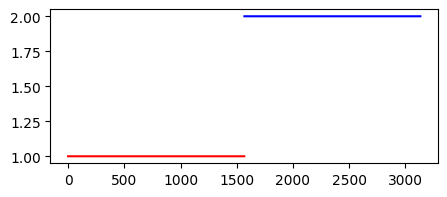

Epoch 1/10
25/25 [==============================] - 59s 768ms/step - loss: 1.0988 - sparse_categorical_accuracy: 0.1301 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.1073
Epoch 2/10
25/25 [==============================] - 15s 621ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.2073 - val_loss: 1.1001 - val_sparse_categorical_accuracy: 0.2133
Epoch 3/10
25/25 [==============================] - 15s 625ms/step - loss: 1.0985 - sparse_categorical_accuracy: 0.3871 - val_loss: 1.0991 - val_sparse_categorical_accuracy: 0.3902
Epoch 4/10
25/25 [==============================] - 15s 623ms/step - loss: 1.0983 - sparse_categorical_accuracy: 0.4171 - val_loss: 1.1016 - val_sparse_categorical_accuracy: 0.3250
Epoch 5/10
25/25 [==============================] - 16s 645ms/step - loss: 1.0984 - sparse_categorical_accuracy: 0.3801 - val_loss: 1.1015 - val_sparse_categorical_accuracy: 0.3870
Epoch 6/10
25/25 [==============================] - 12s 482ms/step - loss: 1.0979 - sparse_cate

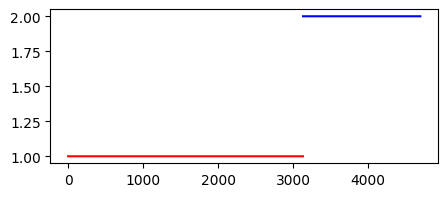

Epoch 1/10
49/49 [==============================] - 24s 493ms/step - loss: 1.0973 - sparse_categorical_accuracy: 0.4601 - val_loss: 1.1070 - val_sparse_categorical_accuracy: 0.4630
Epoch 2/10
49/49 [==============================] - 22s 448ms/step - loss: 1.0970 - sparse_categorical_accuracy: 0.4943 - val_loss: 1.0904 - val_sparse_categorical_accuracy: 0.5690
Epoch 3/10
49/49 [==============================] - 21s 435ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.4480 - val_loss: 1.1064 - val_sparse_categorical_accuracy: 0.4885
Epoch 4/10
49/49 [==============================] - 25s 499ms/step - loss: 1.0959 - sparse_categorical_accuracy: 0.4553 - val_loss: 1.0991 - val_sparse_categorical_accuracy: 0.5613
Epoch 5/10
49/49 [==============================] - 23s 472ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.4493 - val_loss: 1.1003 - val_sparse_categorical_accuracy: 0.5524
Epoch 6/10
49/49 [==============================] - 23s 469ms/step - loss: 1.0945 - sparse_cate

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.05
num_layers= 10
l2_rate = 0.0
lr = 5e-5
opt = keras.optimizers.Adam(learning_rate= lr)
keras_lstm = create_keras_model(inp_size=inp_size, hidden_size=hidden_size, output_size=output_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
keras_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    keras_lstm.fit(X_train, y_train,epochs=10, batch_size=64, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  keras_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### AttentionLSTM

This is fold n 1
Train class distribution: [1275  131  162]
Validation class distribution: [1283  114  169]
Class weights {0: 0.4099346405228758, 1: 3.989821882951654, 2: 3.2263374485596708}


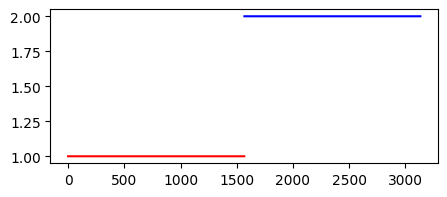

Epoch 1/10
49/49 [==============================] - 81s 915ms/step - loss: 1.0995 - sparse_categorical_accuracy: 0.6193 - val_loss: 1.0924 - val_sparse_categorical_accuracy: 0.5958
Epoch 2/10
49/49 [==============================] - 36s 745ms/step - loss: 1.0983 - sparse_categorical_accuracy: 0.5281 - val_loss: 1.0920 - val_sparse_categorical_accuracy: 0.5613
Epoch 3/10
49/49 [==============================] - 37s 762ms/step - loss: 1.0974 - sparse_categorical_accuracy: 0.3489 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.3455
Epoch 4/10
49/49 [==============================] - 36s 735ms/step - loss: 1.0953 - sparse_categorical_accuracy: 0.2213 - val_loss: 1.0926 - val_sparse_categorical_accuracy: 0.1392
Epoch 5/10
49/49 [==============================] - 40s 814ms/step - loss: 1.0949 - sparse_categorical_accuracy: 0.2608 - val_loss: 1.0850 - val_sparse_categorical_accuracy: 0.2803
Epoch 6/10
49/49 [==============================] - 35s 726ms/step - loss: 1.0920 - sparse_cate

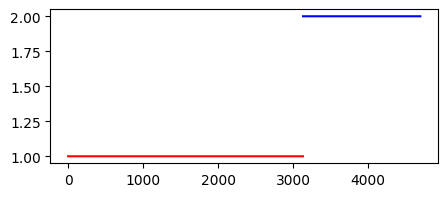

Epoch 1/10
98/98 [==============================] - 151s 1s/step - loss: 1.0998 - sparse_categorical_accuracy: 0.3299 - val_loss: 1.0961 - val_sparse_categorical_accuracy: 0.3653
Epoch 2/10
98/98 [==============================] - 101s 1s/step - loss: 1.0955 - sparse_categorical_accuracy: 0.4253 - val_loss: 1.1051 - val_sparse_categorical_accuracy: 0.2739
Epoch 3/10
98/98 [==============================] - 113s 1s/step - loss: 1.0952 - sparse_categorical_accuracy: 0.3290 - val_loss: 1.1270 - val_sparse_categorical_accuracy: 0.2407
Epoch 4/10
98/98 [==============================] - 116s 1s/step - loss: 1.0948 - sparse_categorical_accuracy: 0.3548 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.2886
Epoch 5/10
98/98 [==============================] - 111s 1s/step - loss: 1.0940 - sparse_categorical_accuracy: 0.3711 - val_loss: 1.0978 - val_sparse_categorical_accuracy: 0.3001
Epoch 6/10
98/98 [==============================] - 110s 1s/step - loss: 1.0917 - sparse_categorical_accu

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.05
num_layers= 10
l2_rate = 0.0
lr = 5e-5


opt = keras.optimizers.Adam(learning_rate= lr)
att_lstm = build_attention_model(input_shape=X_tr.shape[1:], hidden_size=hidden_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
att_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    att_lstm.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  att_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


#### BEST

This is fold n 1
Train class distribution: [1275  131  162]
Validation class distribution: [1283  114  169]
Class weights {0: 0.4099346405228758, 1: 3.989821882951654, 2: 3.2263374485596708}


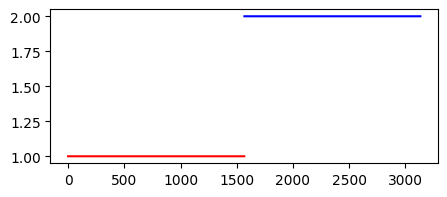

Epoch 1/10
49/49 [==============================] - 84s 981ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.6154 - val_loss: 1.0974 - val_sparse_categorical_accuracy: 0.1935
Epoch 2/10
49/49 [==============================] - 38s 766ms/step - loss: 1.0987 - sparse_categorical_accuracy: 0.3138 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.2899
Epoch 3/10
49/49 [==============================] - 34s 700ms/step - loss: 1.0985 - sparse_categorical_accuracy: 0.2079 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.2312
Epoch 4/10
49/49 [==============================] - 39s 793ms/step - loss: 1.0973 - sparse_categorical_accuracy: 0.3546 - val_loss: 1.0950 - val_sparse_categorical_accuracy: 0.2158
Epoch 5/10
49/49 [==============================] - 38s 787ms/step - loss: 1.0965 - sparse_categorical_accuracy: 0.2570 - val_loss: 1.0964 - val_sparse_categorical_accuracy: 0.1571
Epoch 6/10
49/49 [==============================] - 37s 745ms/step - loss: 1.0948 - sparse_cate

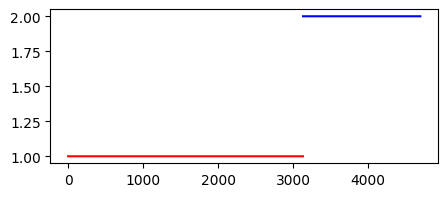

Epoch 1/10
98/98 [==============================] - 102s 743ms/step - loss: 1.1008 - sparse_categorical_accuracy: 0.2974 - val_loss: 1.1059 - val_sparse_categorical_accuracy: 0.3710
Epoch 2/10
98/98 [==============================] - 73s 742ms/step - loss: 1.0956 - sparse_categorical_accuracy: 0.4097 - val_loss: 1.1080 - val_sparse_categorical_accuracy: 0.3908
Epoch 3/10
98/98 [==============================] - 75s 765ms/step - loss: 1.0953 - sparse_categorical_accuracy: 0.4438 - val_loss: 1.0666 - val_sparse_categorical_accuracy: 0.5568
Epoch 4/10
98/98 [==============================] - 72s 740ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.4869 - val_loss: 1.1414 - val_sparse_categorical_accuracy: 0.2458
Epoch 5/10
98/98 [==============================] - 75s 769ms/step - loss: 1.0944 - sparse_categorical_accuracy: 0.3526 - val_loss: 1.1009 - val_sparse_categorical_accuracy: 0.3895
Epoch 6/10
98/98 [==============================] - 72s 742ms/step - loss: 1.0903 - sparse_cat

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.05
num_layers= 10
l2_rate = 0.0
lr = 5e-5
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1), lr_scheduler]

opt = keras.optimizers.Adam(learning_rate= lr)
att_lstm = build_attention_model(input_shape=X_tr.shape[1:], hidden_size=hidden_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
att_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    att_lstm.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  att_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### Transformer

This is fold n 1
Train class distribution: [1275  131  162]
Validation class distribution: [1283  114  169]
Class weights {0: 0.4099346405228758, 1: 3.989821882951654, 2: 3.2263374485596708}


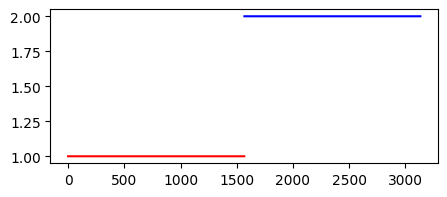

Epoch 1/10
49/49 [==============================] - 5s 57ms/step - loss: 1.2919 - sparse_categorical_accuracy: 0.1926 - val_loss: 1.0880 - val_sparse_categorical_accuracy: 0.4246
Epoch 2/10
49/49 [==============================] - 2s 50ms/step - loss: 1.1299 - sparse_categorical_accuracy: 0.4101 - val_loss: 1.1260 - val_sparse_categorical_accuracy: 0.3614
Epoch 3/10
49/49 [==============================] - 2s 49ms/step - loss: 1.1090 - sparse_categorical_accuracy: 0.4139 - val_loss: 1.1228 - val_sparse_categorical_accuracy: 0.3640
Epoch 4/10
49/49 [==============================] - 2s 46ms/step - loss: 1.1023 - sparse_categorical_accuracy: 0.3999 - val_loss: 1.1226 - val_sparse_categorical_accuracy: 0.3659
Epoch 5/10
49/49 [==============================] - 2s 35ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.3635 - val_loss: 1.1179 - val_sparse_categorical_accuracy: 0.3685
Epoch 6/10
49/49 [==============================] - 2s 37ms/step - loss: 1.0850 - sparse_categorical_accu

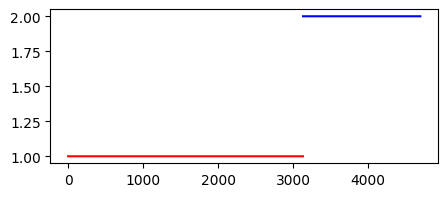

Epoch 1/10
98/98 [==============================] - 10s 35ms/step - loss: 1.1035 - sparse_categorical_accuracy: 0.3685 - val_loss: 1.0970 - val_sparse_categorical_accuracy: 0.3748
Epoch 2/10
98/98 [==============================] - 3s 34ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.4043 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.3895
Epoch 3/10
98/98 [==============================] - 5s 47ms/step - loss: 1.0878 - sparse_categorical_accuracy: 0.3893 - val_loss: 1.1056 - val_sparse_categorical_accuracy: 0.3576
Epoch 4/10
98/98 [==============================] - 3s 33ms/step - loss: 1.0811 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.1062 - val_sparse_categorical_accuracy: 0.3512
Epoch 5/10
98/98 [==============================] - 3s 34ms/step - loss: 1.0817 - sparse_categorical_accuracy: 0.4174 - val_loss: 1.1287 - val_sparse_categorical_accuracy: 0.3167
Epoch 6/10
98/98 [==============================] - 3s 35ms/step - loss: 1.0703 - sparse_categorical_acc

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.05
num_layers= 10
l2_rate = 0.0
lr = 5e-5
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1), lr_scheduler]

opt = keras.optimizers.Adam(learning_rate= lr)
# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=4,
    num_heads=8,
    ff_dim=8,
    num_transformer_blocks=1,
    mlp_units=[32],
    mlp_dropout=0.1,
    dropout=0.1,
l2_rate = 0.0)

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"])#keras.optimizers.Adam(learning_rate=lr)
# Train the model

# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    model_transformer.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


This is fold n 1
Train class distribution: [1275  131  162]
Validation class distribution: [1283  114  169]
Class weights {0: 0.4099346405228758, 1: 3.989821882951654, 2: 3.2263374485596708}


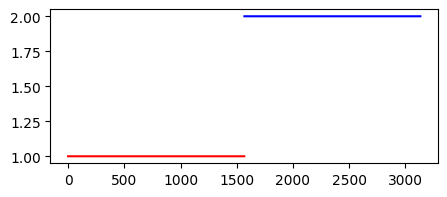

Epoch 1/10
49/49 [==============================] - 7s 52ms/step - loss: 3.4227 - sparse_categorical_accuracy: 0.3865 - val_loss: 3.1970 - val_sparse_categorical_accuracy: 0.3014
Epoch 2/10
49/49 [==============================] - 2s 44ms/step - loss: 2.9677 - sparse_categorical_accuracy: 0.3099 - val_loss: 2.7956 - val_sparse_categorical_accuracy: 0.3065
Epoch 3/10
49/49 [==============================] - 2s 41ms/step - loss: 2.6041 - sparse_categorical_accuracy: 0.3533 - val_loss: 2.4447 - val_sparse_categorical_accuracy: 0.3461
Epoch 4/10
49/49 [==============================] - 3s 54ms/step - loss: 2.2987 - sparse_categorical_accuracy: 0.3463 - val_loss: 2.1892 - val_sparse_categorical_accuracy: 0.3231
Epoch 5/10
49/49 [==============================] - 3s 64ms/step - loss: 2.0422 - sparse_categorical_accuracy: 0.3693 - val_loss: 1.9735 - val_sparse_categorical_accuracy: 0.3212
Epoch 6/10
49/49 [==============================] - 2s 45ms/step - loss: 1.8399 - sparse_categorical_accu

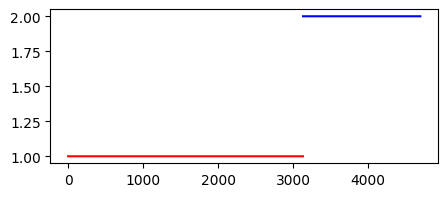

Epoch 1/10
98/98 [==============================] - 6s 38ms/step - loss: 1.2830 - sparse_categorical_accuracy: 0.3749 - val_loss: 1.2506 - val_sparse_categorical_accuracy: 0.3289
Epoch 2/10
98/98 [==============================] - 6s 63ms/step - loss: 1.1823 - sparse_categorical_accuracy: 0.3835 - val_loss: 1.1862 - val_sparse_categorical_accuracy: 0.3365
Epoch 3/10
98/98 [==============================] - 4s 37ms/step - loss: 1.1185 - sparse_categorical_accuracy: 0.3976 - val_loss: 1.1338 - val_sparse_categorical_accuracy: 0.3570
Epoch 4/10
98/98 [==============================] - 4s 39ms/step - loss: 1.0816 - sparse_categorical_accuracy: 0.4170 - val_loss: 1.1356 - val_sparse_categorical_accuracy: 0.3193
Epoch 5/10
98/98 [==============================] - 5s 49ms/step - loss: 1.0562 - sparse_categorical_accuracy: 0.4087 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.3525
Epoch 6/10
98/98 [==============================] - 5s 46ms/step - loss: 1.0371 - sparse_categorical_accu

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.05
num_layers= 10
l2_rate = 0.0
lr = 5e-5
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1), lr_scheduler]

opt = keras.optimizers.Adam(learning_rate= lr)
# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=2,
    num_heads=6,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[32],
    mlp_dropout=0.1,
    dropout=0.1,
l2_rate = 0.1)

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"])#keras.optimizers.Adam(learning_rate=lr)
# Train the model

# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    model_transformer.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### Random Forest Classifier

Train class distribution: [765  74 101]
Validation class distribution: [765  77  98]
Class weights {0: 0.4095860566448802, 1: 4.2342342342342345, 2: 3.102310231023102}


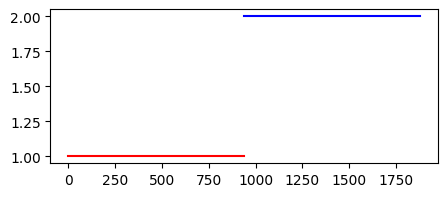

Train class distribution: [1530  151  199]
Validation class distribution: [762  73 105]
Class weights {0: 0.4095860566448802, 1: 4.150110375275938, 2: 3.1490787269681744}


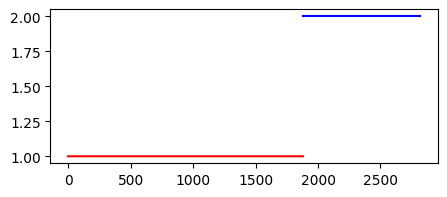

Train class distribution: [2292  224  304]
Validation class distribution: [778  79  83]
Class weights {0: 0.41012216404886565, 1: 4.196428571428571, 2: 3.0921052631578947}


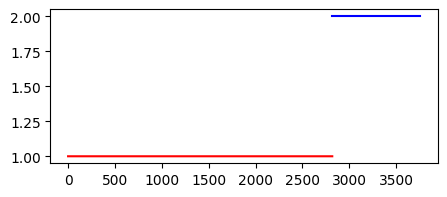

Train class distribution: [3070  303  387]
Validation class distribution: [764  87  89]
Class weights {0: 0.40825190010857765, 1: 4.136413641364136, 2: 3.2385874246339363}


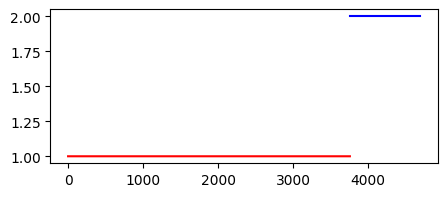

              precision    recall  f1-score   support

        Hold       0.80      0.36      0.50       926
        Sell       0.12      0.38      0.18       110
         Buy       0.12      0.40      0.18       110

    accuracy                           0.37      1146
   macro avg       0.35      0.38      0.29      1146
weighted avg       0.67      0.37      0.44      1146



In [ ]:
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)
X_flattened = X_tr.reshape(X_tr.shape[0], -1)
X_te_flattened = X_te.reshape(X_te.shape[0], -1)

for train_index, test_index in tscv.split(X_flattened):
    X_train, X_test = X_flattened[train_index], X_flattened[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
        #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))
    # calculate time-varying class distributions
    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators = 10, max_depth = 4, random_state=42,class_weight = class_w)
    clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_te_flattened)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred, target_names=target_names,zero_division = 1))


# NETFLIX day analysis

### Read the data

In [ ]:
if __name__ == "__main__":
    # Set the stock symbol, start date, and end date
    stock_symbol = "NFLX"  # Replace with the desired stock symbol
    start_date = "2002-05-23"  # Replace with the desired start date (YYYY-MM-DD format)
    end_date = "2023-08-11"  # Replace with the desired end date (YYYY-MM-DD format)

    # Get the stock data
    data = get_stock_data(stock_symbol, start_date, end_date)
    data.sort_index(ascending=True, inplace=True)
    if data is not None:
      data["Date"] = data.index
      data['Net'] = data['Close'].diff()
      data["Net"].fillna(0.0, inplace=True)
      data = data.drop(['Adj Close'], axis=1)

data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Date,Net
Date,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000,2002-05-23,0.000000
2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800,2002-05-24,0.013571
2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400,2002-05-28,-0.052857
2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800,2002-05-29,-0.053572
2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200,2002-05-30,-0.032142
...,...,...,...,...,...,...,...
2023-08-04,433.059998,436.500000,426.269989,431.600006,5439700,2023-08-04,0.600006
2023-08-07,436.459991,441.109985,428.910004,440.760010,4781300,2023-08-07,9.160004
2023-08-08,440.359985,443.570007,435.100006,438.299988,3767200,2023-08-08,-2.460022


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5341 entries, 2002-05-23 to 2023-08-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5341 non-null   float64       
 1   High    5341 non-null   float64       
 2   Low     5341 non-null   float64       
 3   Close   5341 non-null   float64       
 4   Volume  5341 non-null   int64         
 5   Date    5341 non-null   datetime64[ns]
 6   Net     5341 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 333.8 KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5341 entries, 2002-05-23 to 2023-08-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5341 non-null   float64       
 1   High    5341 non-null   float64       
 2   Low     5341 non-null   float64       
 3   Close   5341 non-null   float64       
 4   Volume  5341 non-null   int64         
 5   Date    5341 non-null   datetime64[ns]
 6   Net     5341 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 333.8 KB


###Data Preprocessing

In [ ]:
#data["%Chg"] = new_chg(data["%Chg"])
data["Volume"] = obj_to_float(data["Volume"])
#data['Exchange Date'] = new_date(data['Exchange Date'])
data['Date'] = new_date(data['Date'])


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5341 entries, 2002-05-23 to 2023-08-10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5341 non-null   float64       
 1   High    5341 non-null   float64       
 2   Low     5341 non-null   float64       
 3   Close   5341 non-null   float64       
 4   Volume  5341 non-null   float64       
 5   Date    5341 non-null   datetime64[ns]
 6   Net     5341 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 333.8 KB


 We need to realize that there are too many datapoints because date and time do not account for hours in which the market is closed and prices do not move. Therefore, we need to remove redundant times.

In [ ]:

data.reset_index(drop=True, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5341 entries, 0 to 5340
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Open    5341 non-null   float64       
 1   High    5341 non-null   float64       
 2   Low     5341 non-null   float64       
 3   Close   5341 non-null   float64       
 4   Volume  5341 non-null   float64       
 5   Date    5341 non-null   datetime64[ns]
 6   Net     5341 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 292.2 KB


In [ ]:
max_value = data['Volume'].max()
data['Volume'] = data['Volume'].replace(max_value, data['Volume'].where(data['Volume'] != max_value).max())

#### Feature Engineering

In [ ]:
period = 20


# Calculate standard deviation
data['std_dev'] = data['Close'].copy().rolling(window=period).std()

# Calculate Williams %R

data['williams_percent_r'] = calculate_williams_percent_r(data['High'], data['Low'], data['Close'], period)
# exponential moving average
data["EMA"] = calculate_ema(data,period)
# residual strength index
data["RSI"] = calculate_rsi(data,period)

# Calculate the 7-day and 30-day moving averages
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_30'] = data['Close'].rolling(window=30).mean()


# Calculate the Moving Average Convergence Divergence (MACD)
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
data['MACD'] = macd - signal


data.head()
data.fillna(data.mean(), inplace = True)


<ipython-input-29-7b061479685a>:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.mean(), inplace = True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5341 entries, 0 to 5340
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Open                5341 non-null   float64       
 1   High                5341 non-null   float64       
 2   Low                 5341 non-null   float64       
 3   Close               5341 non-null   float64       
 4   Volume              5341 non-null   float64       
 5   Date                5341 non-null   datetime64[ns]
 6   Net                 5341 non-null   float64       
 7   std_dev             5341 non-null   float64       
 8   williams_percent_r  5341 non-null   float64       
 9   EMA                 5341 non-null   float64       
 10  RSI                 5341 non-null   float64       
 11  MA_7                5341 non-null   float64       
 12  MA_30               5341 non-null   float64       
 13  MACD                5341 non-null   float64     

### Create Target

#### Set the multi-class target. It consists in either a price stays the same (0) or decrease more than 0.5 std (1) or increase more than 0.5 std (2).

In [ ]:
data["Trend"] = build_target(data["Net"])

#### Target

In [ ]:
#data['Trend'] = np.where(data['Net'] < 0, 1, np.where(data['Net'] > 0, 2, 0))

([<matplotlib.axis.XTick at 0x7b11f18130a0>,
 [Text(0.0, 0, '0'), Text(1.0, 0, '1'), Text(2.0, 0, '2')])

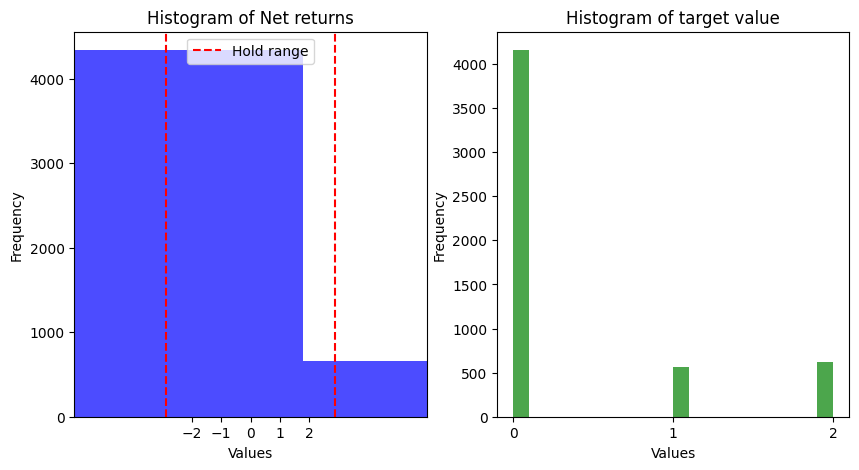

In [ ]:
plt.figure(figsize=(10, 5))

# Plot the first histogram on the left subplot
plt.subplot(1, 2, 1)
plt.hist(data["Net"], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Net returns')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(-6, 6)
plt.axvline(data["Net"].std()*0.5, color='r', linestyle='--', label='Hold range')
plt.axvline(- data["Net"].std()*0.5, color='r', linestyle='--')

# Calculate the number of ticks around zero
num_ticks = 5
# Set the tick positions and labels
ticks = np.linspace(-2, 2, num_ticks)
plt.xticks(ticks)
plt.legend()
# Plot the second histogram on the right subplot
plt.subplot(1, 2, 2)
plt.hist(data["Trend"], bins=20, color='green', alpha=0.7)
plt.title('Histogram of target value')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 2.1, 1)
)

class 0 is weighted 1.0
class 1 is weighted 9.0
class 2 is weighted 8.0


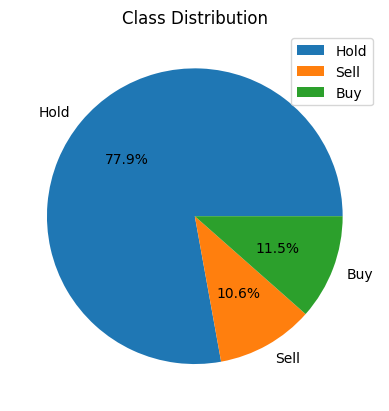

In [ ]:
tgt = data["Trend"]
grows, decrease, same = 0,0,0
for value in tgt:
  if value == 2:
    grows += 1
  elif value == 1:
    decrease += 1
  else:
    same += 1
class_labels = ["Hold",'Sell', 'Buy']
plt.pie([same,decrease,grows], autopct='%1.1f%%' , labels=class_labels)
plt.title("Class Distribution")
plt.legend()
n = len(tgt)
class_weight = [same/n, decrease/n, grows/n]
weight_tensor = loss_weights(class_weight)
for i , val in enumerate(weight_tensor.numpy()) :
  print("class",i,"is weighted",val)

### Feature Selection

In [ ]:
correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)

correlations

<ipython-input-35-ce59e57b9ad5>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data[data.columns[:-1]].corrwith(data['Trend']).sort_values(ascending=False)


Close                 0.647182
High                  0.646412
EMA                   0.642011
Low                   0.641420
MA_30                 0.641209
Open                  0.640347
MA_7                  0.640084
std_dev               0.558105
Net                   0.276698
williams_percent_r    0.070692
MACD                  0.027976
RSI                   0.010017
Volume               -0.106498
dtype: float64

In [ ]:
correlation_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]


<ipython-input-36-5fbb337c4d5d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr().abs()
<ipython-input-36-5fbb337c4d5d>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


In [ ]:
print(to_drop)

['High', 'Low', 'Close', 'EMA', 'RSI', 'MA_7', 'MA_30']


In [ ]:
from sklearn.feature_selection import mutual_info_classif
X = data[["Close","Volume", "Net","williams_percent_r","MACD",'std_dev', 'EMA', 'RSI', 'MA_7', 'MA_30']]
y = data["Trend"]
mi_scores = mutual_info_classif(X, y, random_state=0)

# Create a dataframe of features and their mutual information scores
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})

# Display the dataframe sorted by MI_Score in descending order
mi_scores_df.sort_values('MI_Score', ascending=False)

,Feature,MI_Score
2,Net,0.681223
9,MA_30,0.280833
8,MA_7,0.280031
0,Close,0.278695
6,EMA,0.275287
5,std_dev,0.262980
4,MACD,0.201116
3,williams_percent_r,0.046100
1,Volume,0.027920
7,RSI,0.003354


In [ ]:
columns = mi_scores_df["Feature"].iloc[np.where(mi_scores_df["MI_Score"] > 0.2)].tolist()
columns.append("Trend")
print(columns)

['Close', 'Net', 'MACD', 'std_dev', 'EMA', 'MA_7', 'MA_30', 'Trend']


### Some Visualizations

In [ ]:
df = data.rename("Trend": "Investment Decision")
correlation_matrix = df.corr()
correlation_matrix

<ipython-input-56-6617581d08be>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


,Open,High,Low,Close,Volume,Net,std_dev,williams_percent_r,EMA,RSI,MA_7,MA_30,MACD,Trend
Open,1.000000,0.999847,0.999850,0.999673,-0.276157,0.004134,0.747705,0.026547,0.997786,0.012038,0.998892,0.993635,-0.010424,0.640347
High,0.999847,1.000000,0.999808,0.999857,-0.274810,0.013624,0.749602,0.028170,0.997800,0.012496,0.998843,0.993683,-0.009582,0.646412
Low,0.999850,0.999808,1.000000,0.999844,-0.277575,0.014505,0.744853,0.030132,0.997516,0.014628,0.998716,0.993278,-0.007750,0.641420
Close,0.999673,0.999857,0.999844,1.000000,-0.276016,0.024108,0.747167,0.031694,0.997546,0.014757,0.998662,0.993361,-0.007252,0.647182
Volume,-0.276157,-0.274810,-0.277575,-0.276016,1.000000,-0.027207,-0.158636,-0.032776,-0.273833,-0.024612,-0.274570,-0.274670,-0.014497,-0.106498
Net,0.004134,0.013624,0.014505,0.024108,-0.027207,1.000000,-0.031627,0.225252,-0.005774,0.136648,-0.004436,-0.007784,0.172727,0.276698
std_dev,0.747705,0.749602,0.744853,0.747167,-0.158636,-0.031627,1.000000,-0.042992,0.762975,-0.071461,0.752486,0.771381,-0.117647,0.558105
williams_percent_r,0.026547,0.028170,0.030132,0.031694,-0.032776,0.225252,-0.042992,1.000000,-0.004649,0.834843,0.013073,-0.020113,0.411294,0.070692
EMA,0.997786,0.997800,0.997516,0.997546,-0.273833,-0.005774,0.762975,-0.004649,1.000000,-0.019907,0.998762,0.997798,-0.056856,0.642011
RSI,0.012038,0.012496,0.014628,0.014757,-0.024612,0.136648,-0.071461,0.834843,-0.019907,1.000000,0.001330,-0.040253,0.327838,0.010017


<Axes: >

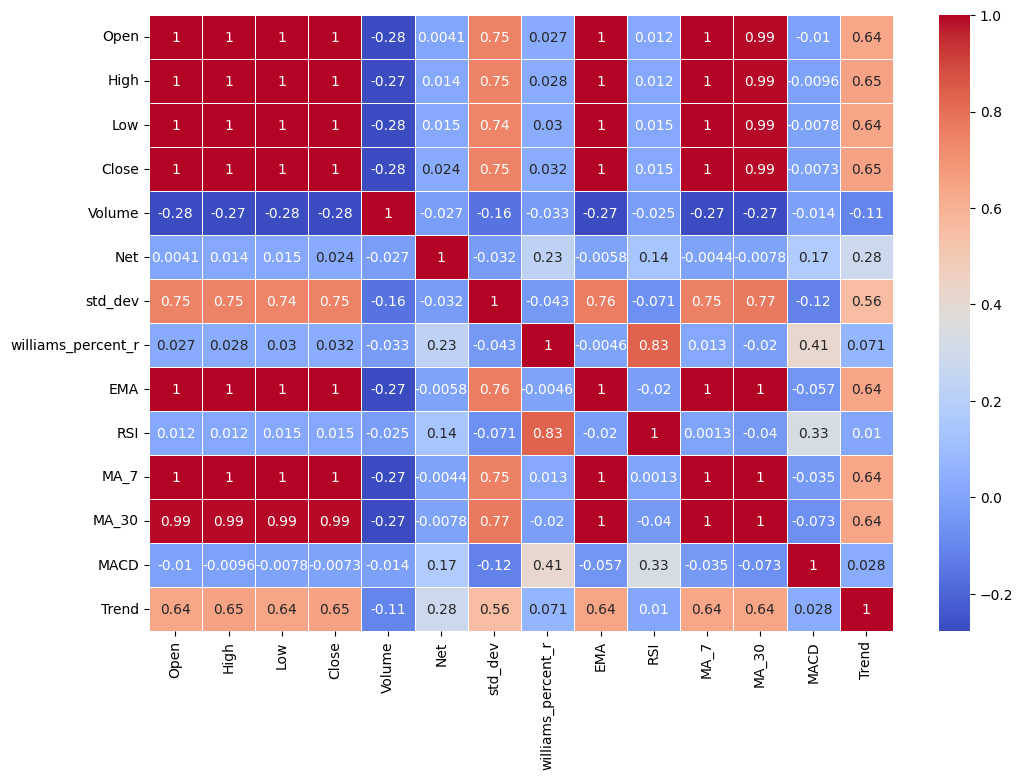

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(correlation_matrix, annot = True ,linewidths=0.5, cmap = "coolwarm")

#### Analyse closing prices

In [ ]:
data["Close"].describe()

count    5341.000000
mean      126.981219
std       170.522175
min         0.372857
25%         4.087143
50%        32.148571
75%       218.509995
max       691.690002
Name: Close, dtype: float64

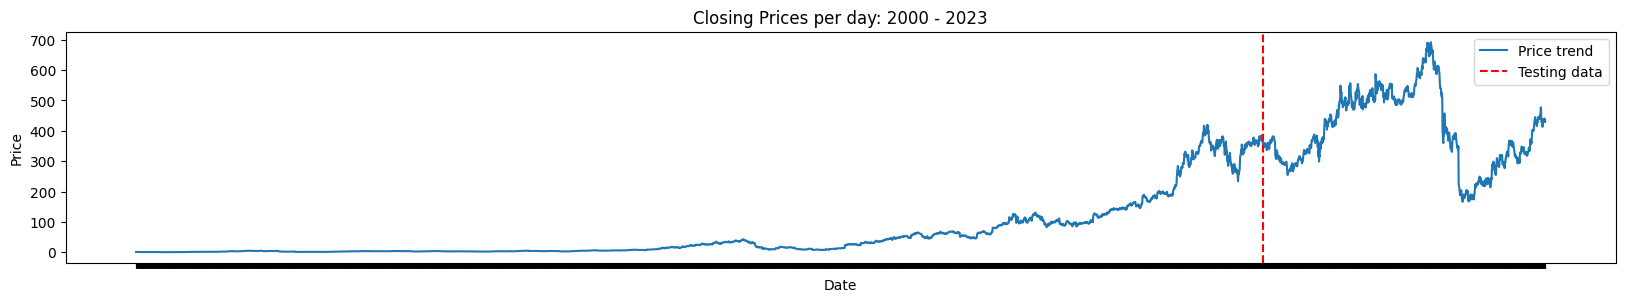

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data["Date"].astype(str), data["Close"])
plt.xlabel('Date')
plt.ylabel('Price')
# Remove tick labels
plt.gca().set_xticklabels([])
plt.axvline(int(len(data["Date"])*0.8), color='r', linestyle='--', label='Testing data')

plt.title('Closing Prices per day: 2000 - 2023')
plt.legend(["Price trend", 'Testing data'],fontsize="10")

Text(0.5, 1.0, 'Count of closing price values')

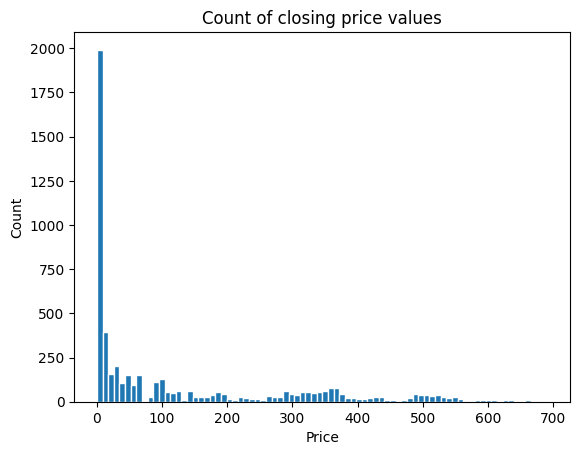

In [ ]:
plt.hist(data["Close"],edgecolor='white', bins = 80)
plt.ylabel("Count")
plt.xlabel("Price")
plt.title("Count of closing price values")

#### Volume

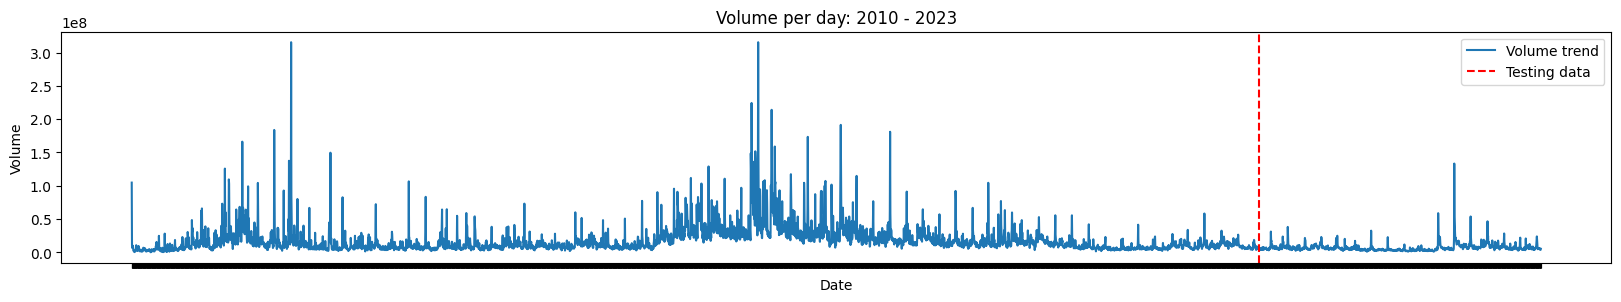

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(data["Date"].astype(str), data["Volume"])
plt.xlabel('Date')
plt.ylabel('Volume')
# Remove tick labels
plt.gca().set_xticklabels([])
plt.axvline(int(len(data["Date"])*0.8), color='r', linestyle='--', label='Testing data')

plt.title('Volume per day: 2010 - 2023')
plt.legend(["Volume trend","Testing data" ],fontsize="10")

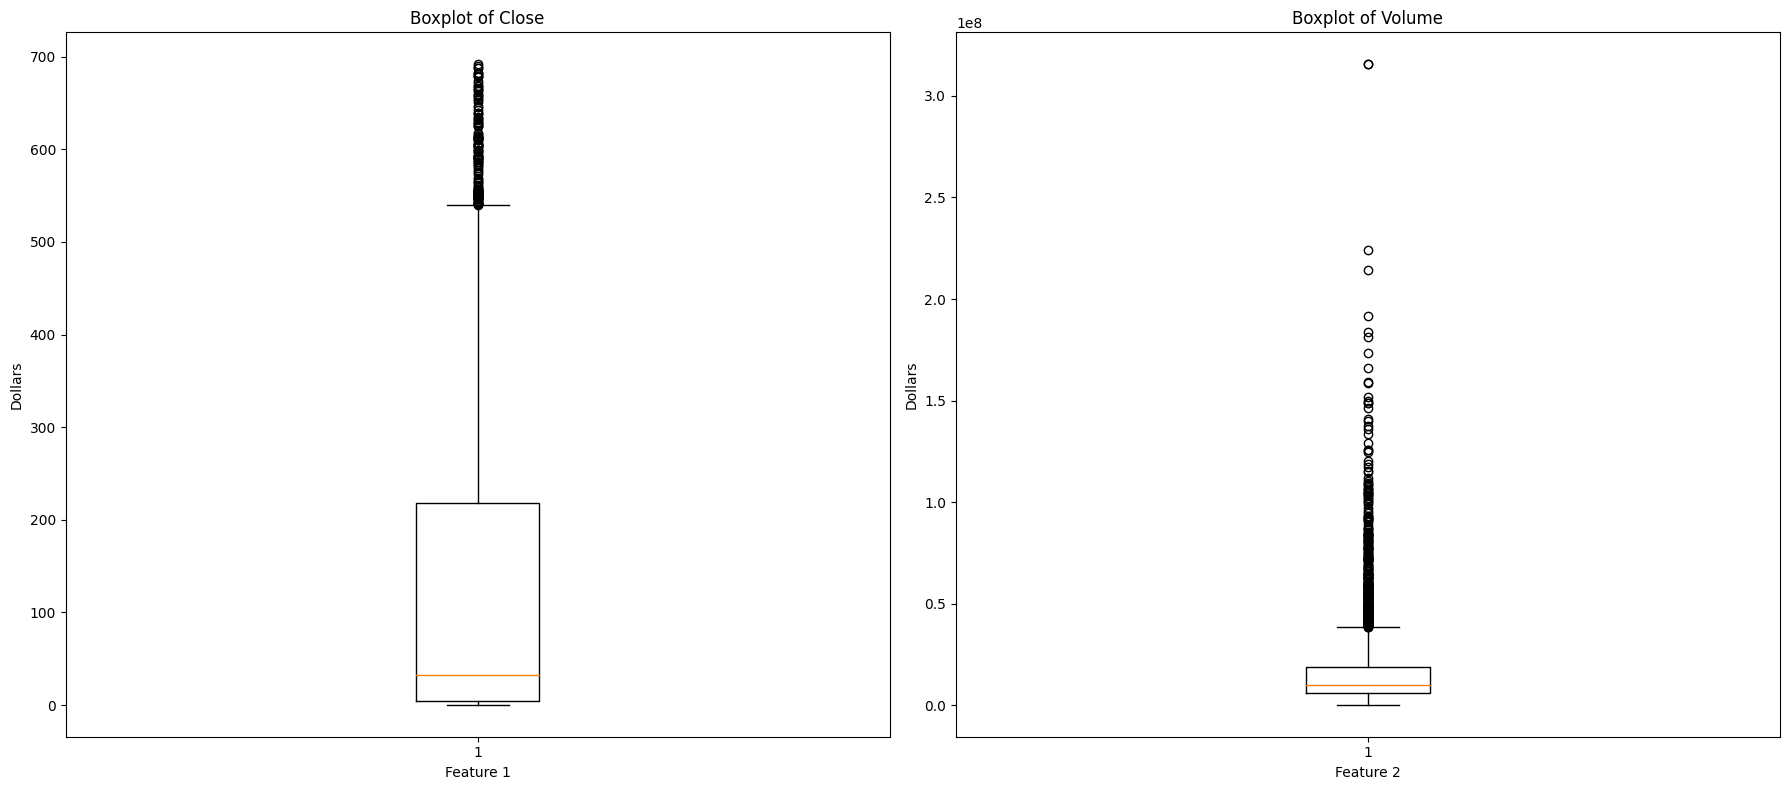

In [ ]:
X_viz = data[["Close", "Volume"]]
boxplot(X_viz)

It is clear that Volume shows exrteme outliers but they are crucial in identifying possible price trends as it represents the level of market activity and liquidity. Therefore, after dropping the very extreme outlier, all the rest is kept.

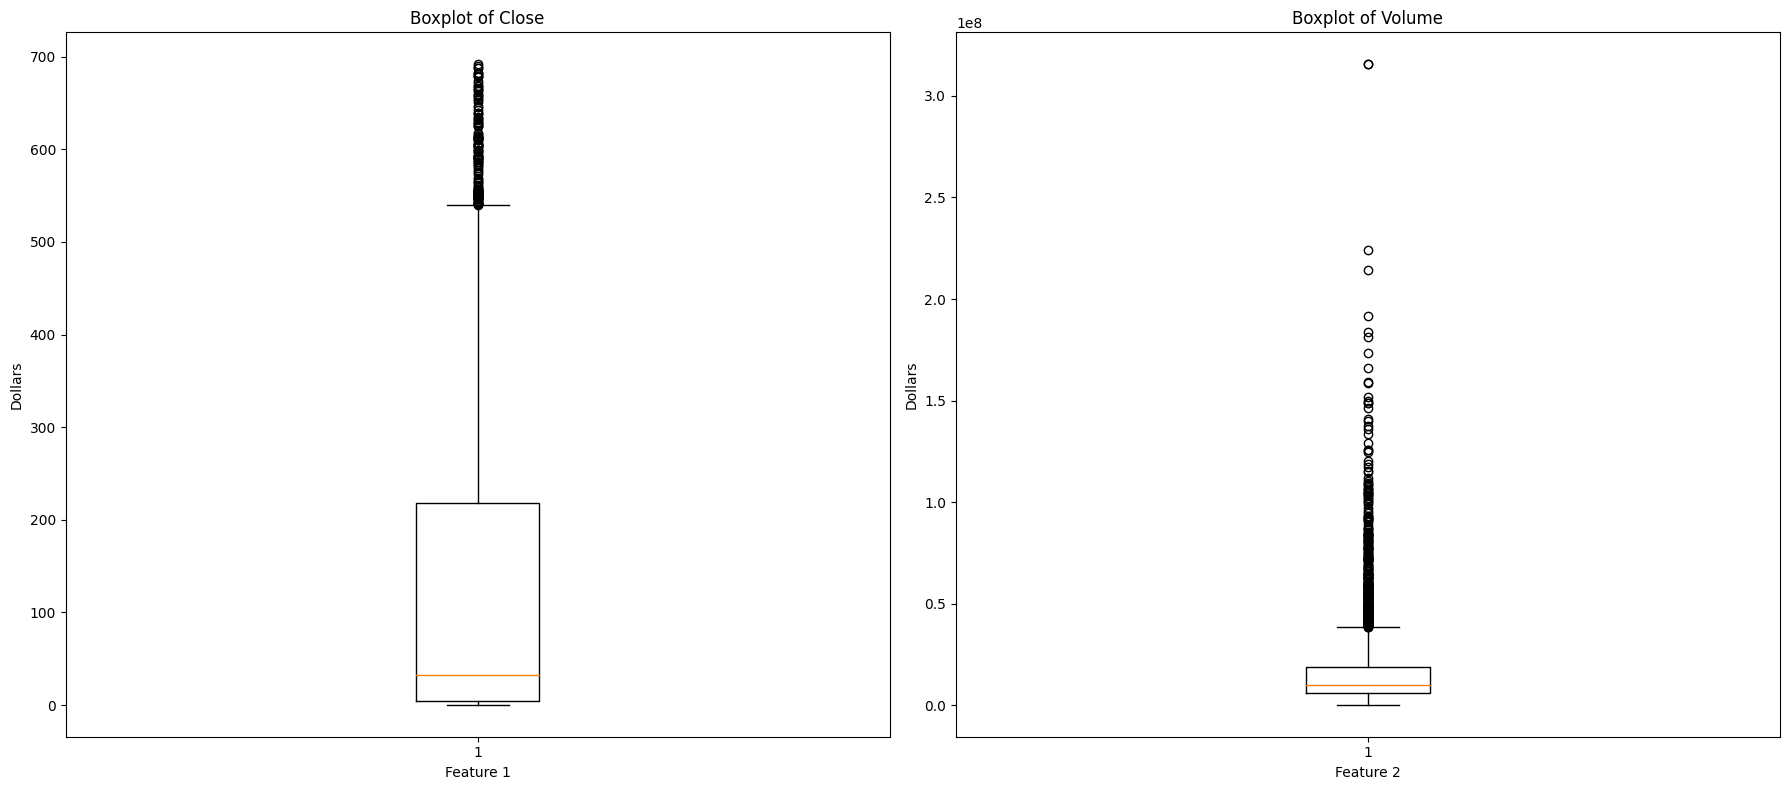

In [ ]:
X_new_vol = data[["Close", "Volume"]]
boxplot(X_new_vol)

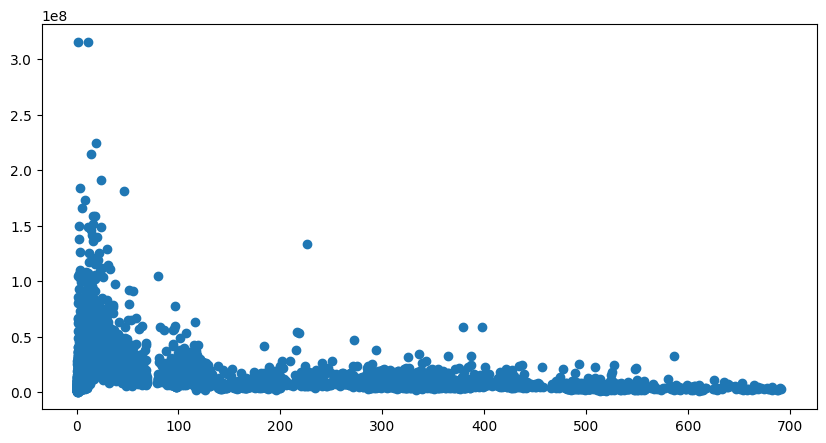

In [ ]:
plt.figure(figsize = (10,5))
plt.scatter(data["Close"],data["Volume"])

#### New Features

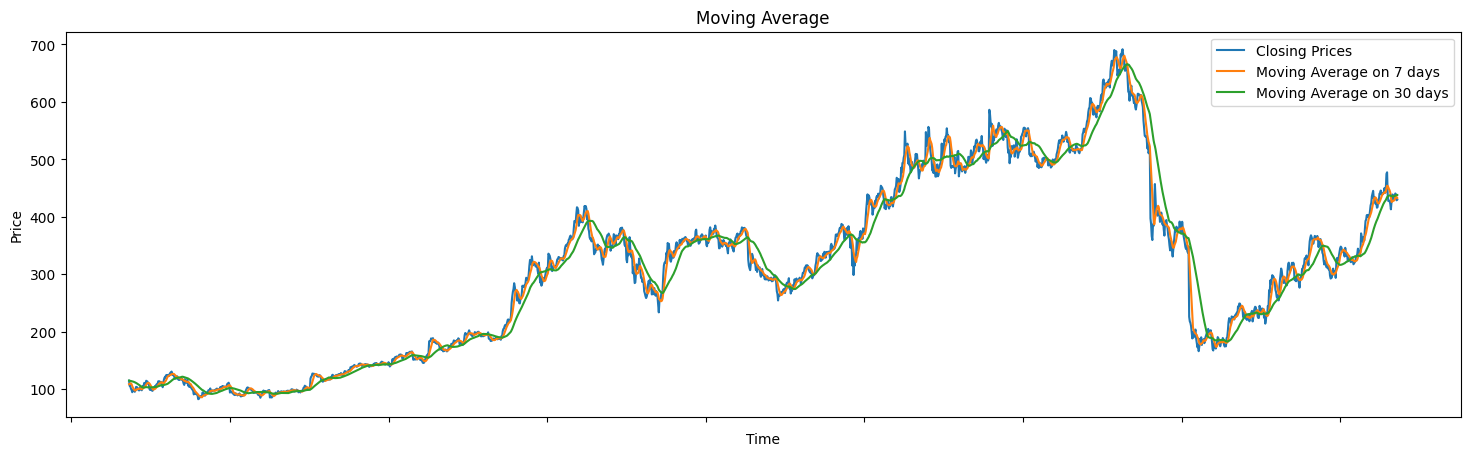

In [ ]:
##MA
plt.figure(figsize = (18,5))
plt.plot(data["Close"][-2000:], label='Closing Prices')
plt.plot(data["MA_7"][-2000:], label='Moving Average on 7 days')
plt.plot(data["MA_30"][-2000:], label='Moving Average on 30 days')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Moving Average')
plt.show()


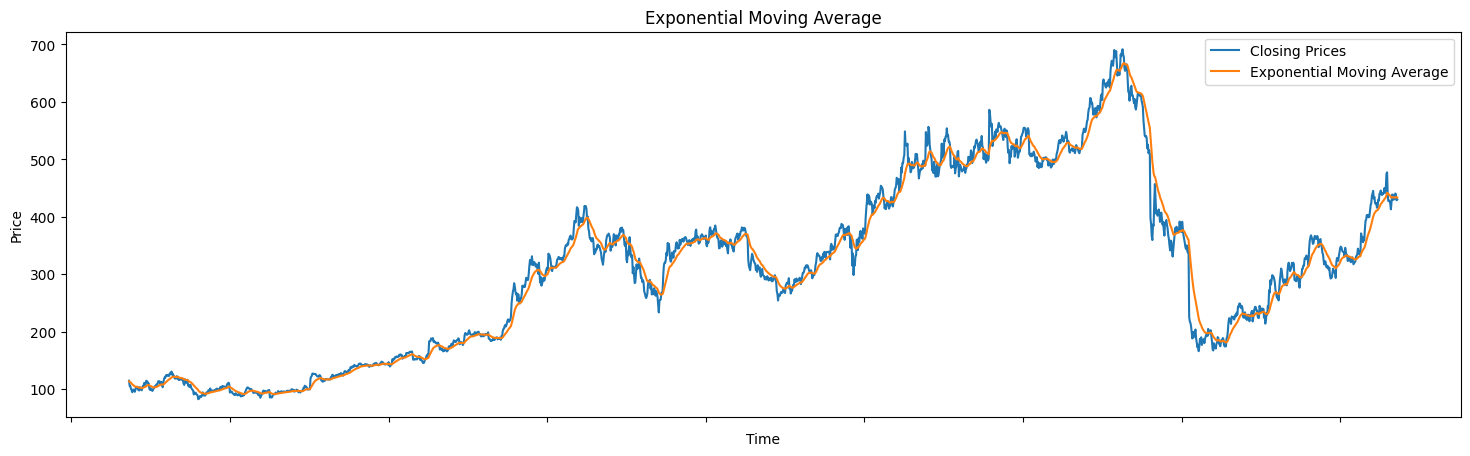

In [ ]:
##EMA
plt.figure(figsize = (18,5))
plt.plot(data["Close"][-2000:], label='Closing Prices')
plt.plot(data["EMA"][-2000:], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('Exponential Moving Average')
plt.show()


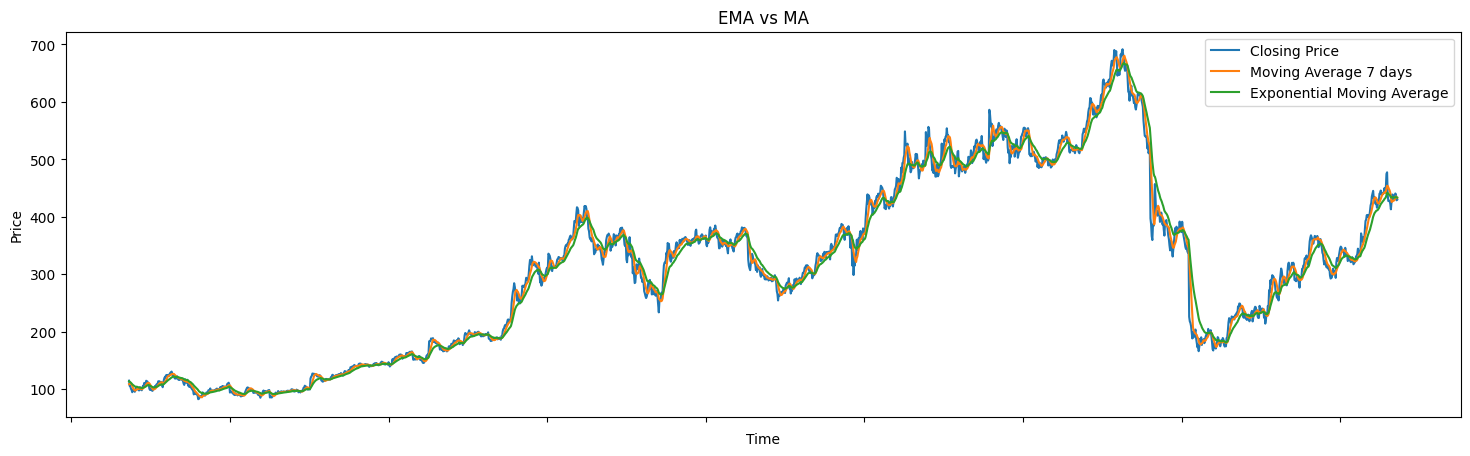

In [ ]:
##EMA vs MS
plt.figure(figsize = (18,5))
plt.plot(data["Close"][-2000:], label='Closing Price')
plt.plot(data["MA_7"][-2000:], label='Moving Average 7 days')
plt.plot(data["EMA"][-2000:], label='Exponential Moving Average')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.gca().set_xticklabels([])
plt.title('EMA vs MA')
plt.show()

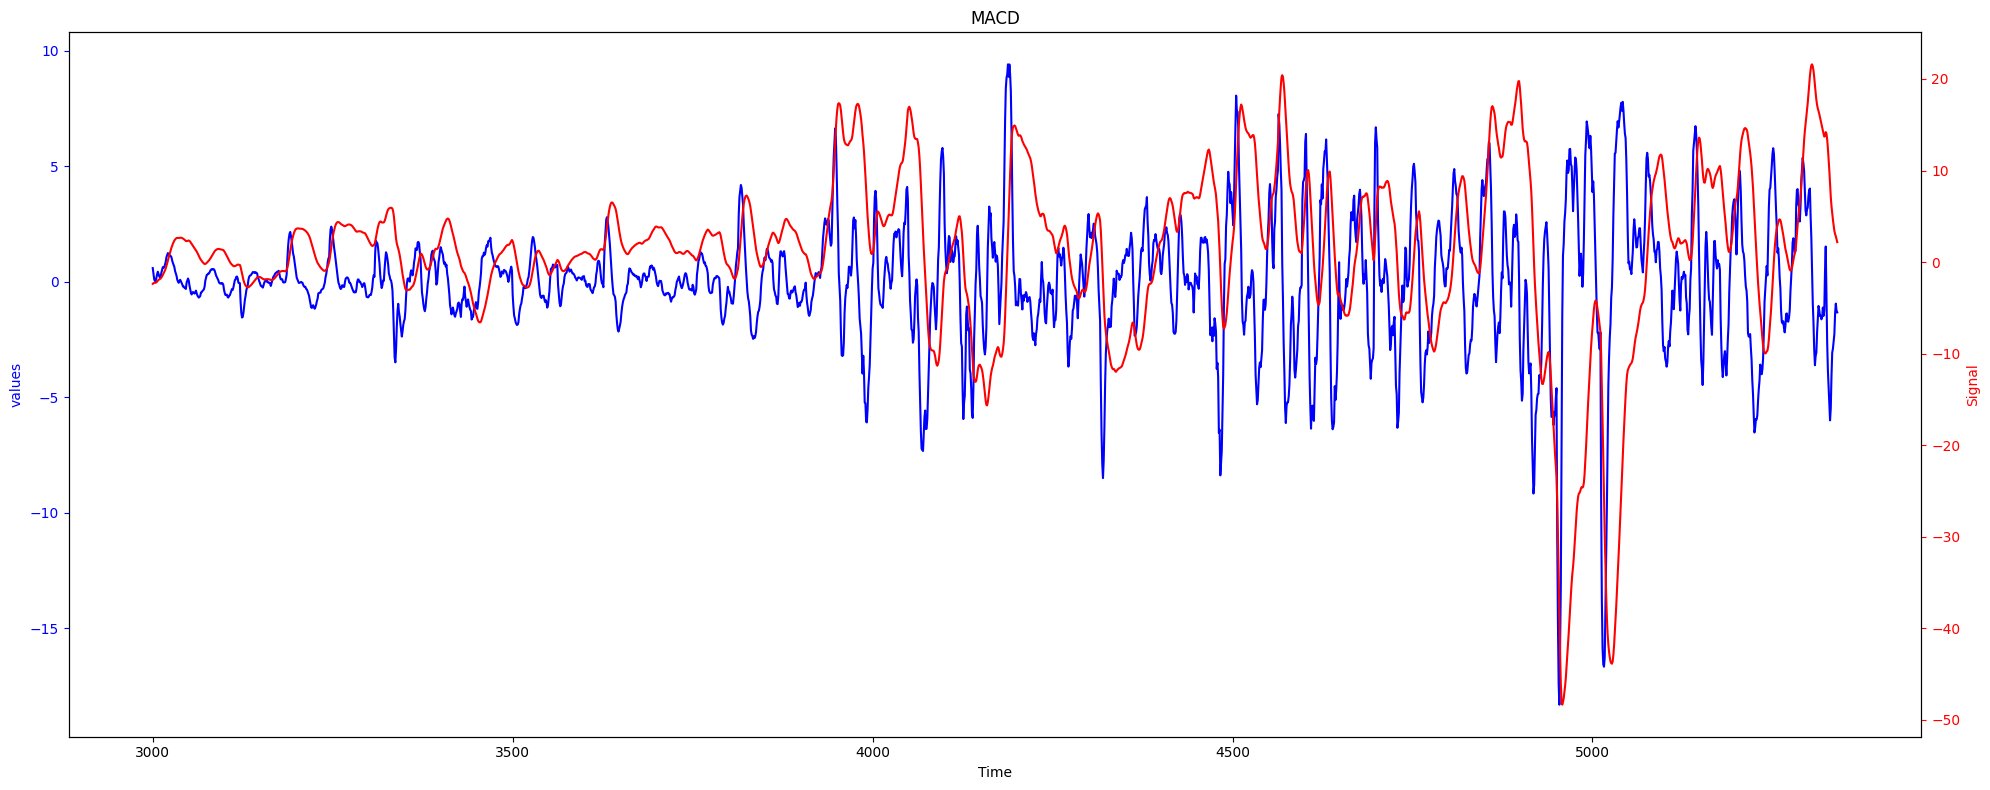

In [ ]:
## STD_DEV
fig, ax1 = plt.subplots(figsize = (20,8))

# Plot the closing prices on the primary y-axis
ax1.plot(data["MACD"][3000:], label='MACD line', color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('values', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for the rolling standard deviation
ax2 = ax1.twinx()
ax2.plot(signal[3000:], label='Signal line', color='r')
ax2.set_ylabel('Signal', color='r')
ax2.tick_params('y', colors='r')

plt.title('MACD')
fig.tight_layout()
plt.show()

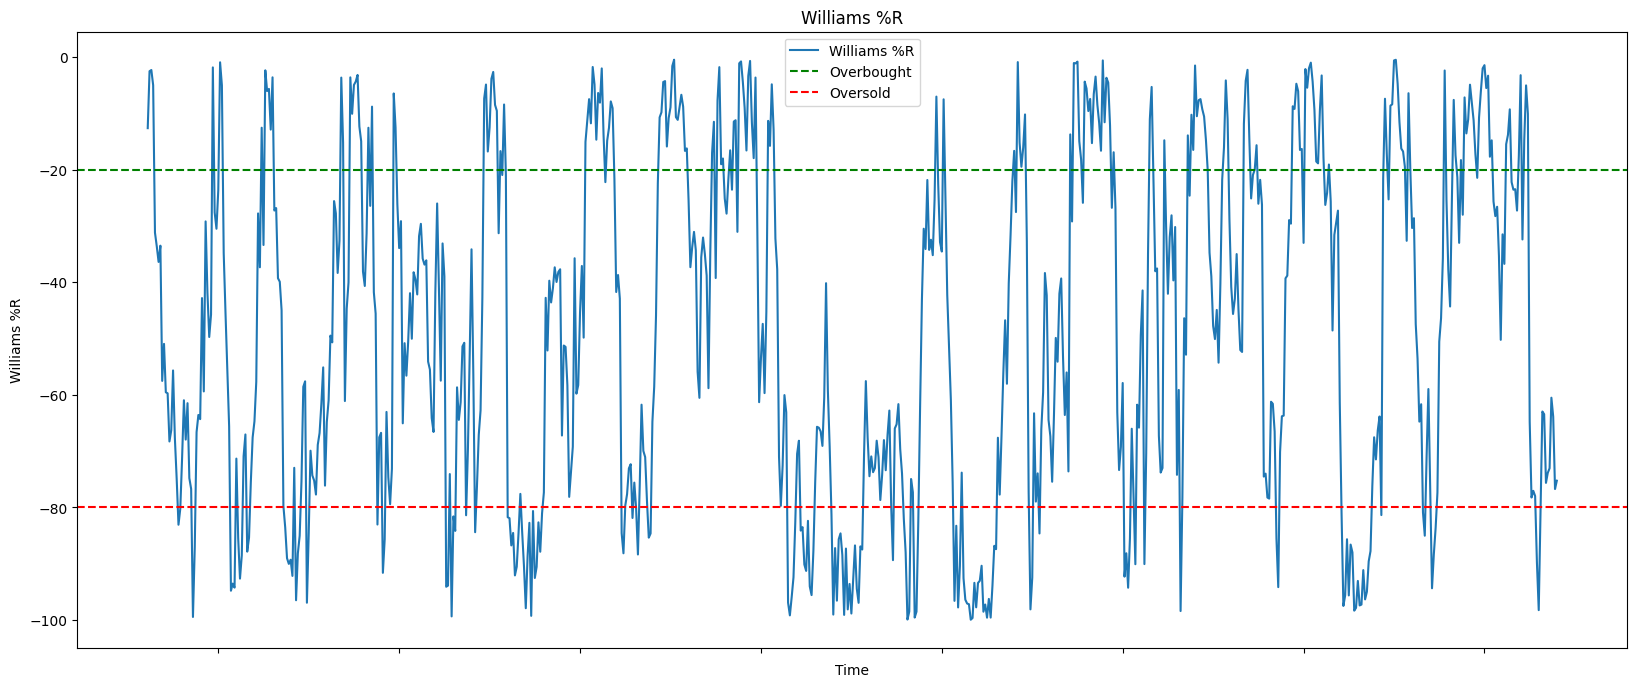

In [ ]:
## WILLIAMS %R
plt.figure(figsize = (20,8))
plt.plot(data["williams_percent_r"][-780:], label='Williams %R') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(-20, color='g', linestyle='--', label='Overbought')
plt.axhline(-80, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('Williams %R')
plt.title('Williams %R')
plt.show()

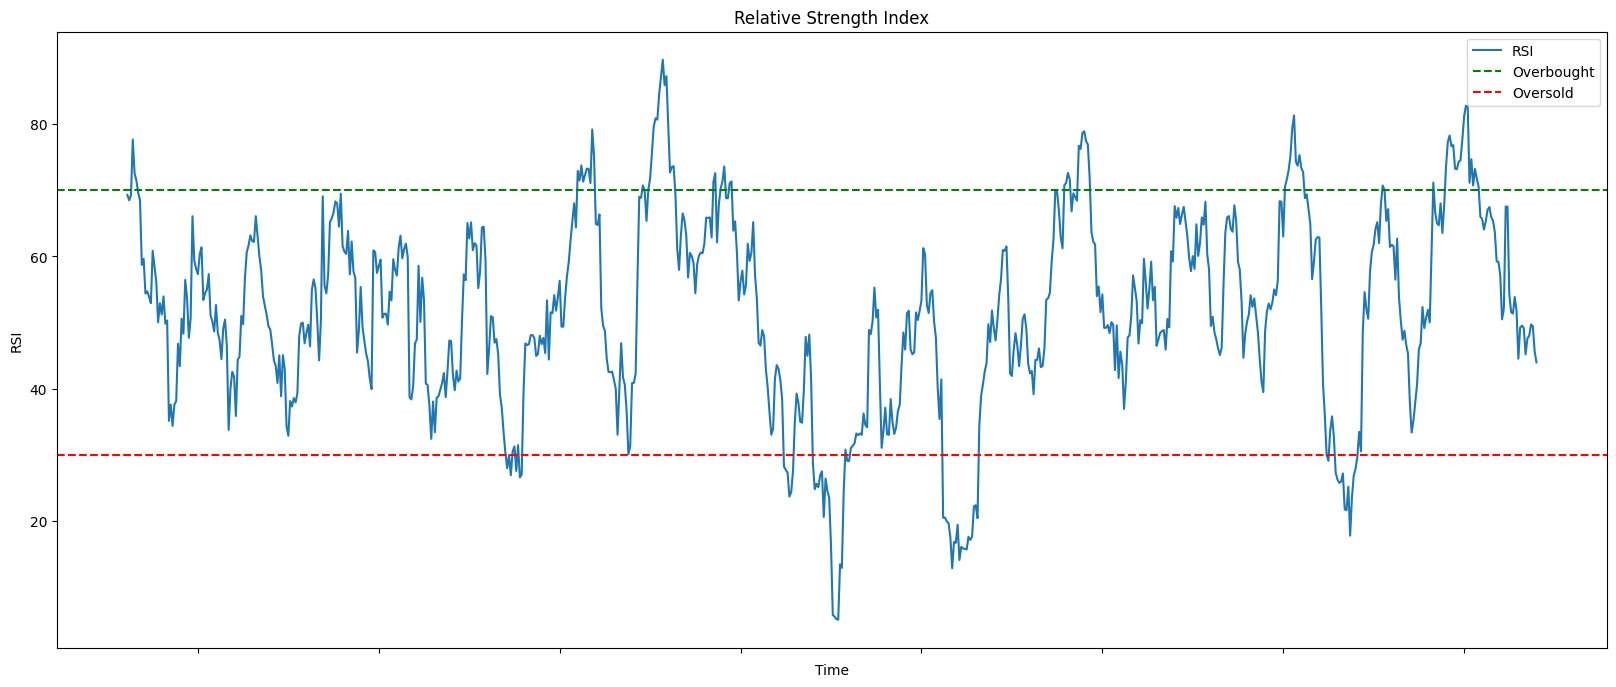

In [ ]:
##RSI
plt.figure(figsize = (20,8))
plt.plot(data["RSI"][-780:], label='RSI') ## ONLY LAST 2-DAYS DATA FOR VISUALIZATION PURPOSES
plt.axhline(70, color='g', linestyle='--', label='Overbought')
plt.axhline(30, color='r', linestyle='--', label='Oversold')
plt.legend()
plt.xlabel('Time')
plt.gca().set_xticklabels([])
plt.ylabel('RSI')
plt.title('Relative Strength Index')
plt.show()

### KERAS TRIAL

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

X_parent = data[columns].copy()
#train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.4)
train,  test = train_test_split(X_parent,test_size = 0.2)

X = train[columns[:-1]]  # All rows, all columns except the last one
y = train["Trend"]   # All rows, only the last column (class labels)
unique, counts = np.unique(y, return_counts=True)

initial_train_class = dict(zip(unique, counts))
print("Train class distribution", initial_train_class)


X_resampled, y_resampled = oversample(X,y,oversampling_ratio = 0.9, maj_class = 0)

train = pd.concat([X_resampled, y_resampled], axis=1)

Train class distribution {0: 3868, 1: 394, 2: 478}
3868
Resampled class distribution {0: 3868, 1: 3481, 2: 3481}


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
#valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns = columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
#valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 40)
#X_v, y_v = generate_keras_dataset(valid ,lookback = 40)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 40)

In [ ]:
print("X_Train shape is:", X_tr.shape)
#print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

X_Train shape is: (10790, 40, 9)
Testing set size is: (1146, 40, 9)


In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
#class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
#print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

Count of classes in the dataset {0: 4829, 1: 507, 2: 590}
Count of classes in the training set {0: 3834, 1: 3477, 2: 3479}
Count of classes in the test set {0: 926, 1: 110, 2: 110}


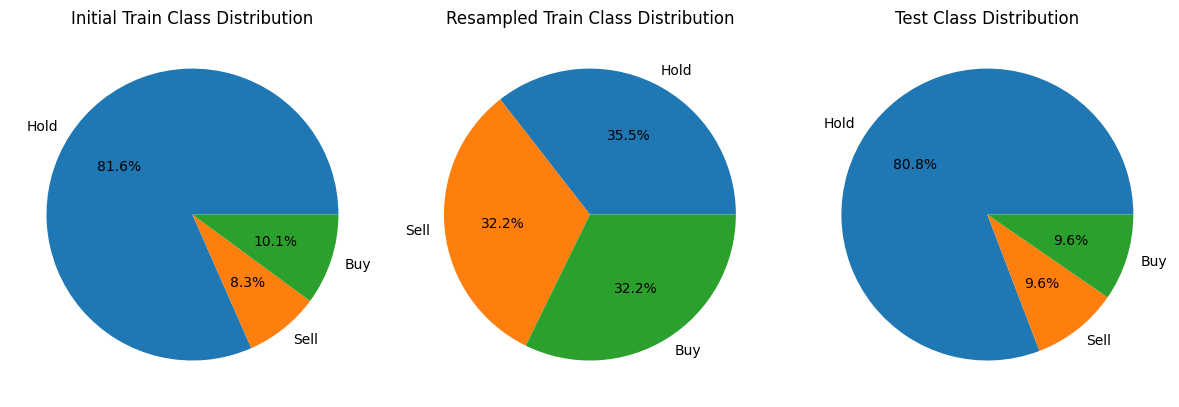

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 3, 1)
plt.pie(initial_train_class.values(), labels=labels, autopct='%1.1f%%')
plt.title("Initial Train Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 3, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title("Resampled Train Class Distribution")

# Plot the second pie chart in the middle subplot
#plt.subplot(1, 4, 3)
#plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
#plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 3, 3)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)


{0: 0.9380977221352809, 1: 1.0344166426996453, 2: 1.0338219794960237}


### KERAS TRIAL 2

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

X_parent = data[columns].copy()
#train, valid, test = train_val_test_k(X_parent,size = 0.8,val_coef = 0.4)
train,  test = train_test_split(X_parent,test_size = 0.2)

X = train[columns[:-1]]  # All rows, all columns except the last one
y = train["Trend"]   # All rows, only the last column (class labels)
unique, counts = np.unique(y, return_counts=True)

initial_train_class = dict(zip(unique, counts))
print("Train class distribution", initial_train_class)



Train class distribution {0: 3310, 1: 454, 2: 508}


In [ ]:
scaler = StandardScaler()
scaler.fit(train[columns[:-1]])
train_scaled = pd.DataFrame(scaler.transform(train[columns[:-1]]), columns = columns[:-1], index=train.index)
#valid_scaled =  pd.DataFrame(scaler.transform(valid[columns[:-1]]), columns = columns[:-1], index=valid.index)
test_scaled =  pd.DataFrame(scaler.transform(test[columns[:-1]]), columns = columns[:-1], index=test.index)

train_scaled["Trend"] = train["Trend"]
#valid_scaled["Trend"] = valid["Trend"]
test_scaled["Trend"] = test["Trend"]

In [ ]:
X_tr, y_tr = generate_keras_dataset(train_scaled,lookback = 40)
#X_v, y_v = generate_keras_dataset(valid ,lookback = 40)
X_te, y_te = generate_keras_dataset(test_scaled ,lookback = 40)

In [ ]:
print("X_Train shape is:", X_tr.shape)
#print("Validation set size is:",X_v.shape)
print("Testing set size is:",X_te.shape)

X_Train shape is: (4232, 40, 7)
Testing set size is: (1029, 40, 7)


In [ ]:
class_counts = {0: np.sum(X_parent.iloc[:,-1] == 0),1: np.sum(X_parent.iloc[:,-1] == 1),2:np.sum(X_parent.iloc[:,-1] == 2)}
print("Count of classes in the dataset", class_counts)
class_counts_train = {0: np.sum(y_tr == 0),1: np.sum(y_tr == 1),2:np.sum(y_tr == 2)}
print("Count of classes in the training set", class_counts_train)
#class_counts_val = {0: np.sum(y_v == 0),1: np.sum(y_v == 1),2:np.sum(y_v == 2)}
#print("Count of classes in the validation set", class_counts_val)
class_counts_test = {0: np.sum(y_te == 0),1: np.sum(y_te == 1),2:np.sum(y_te == 2)}
print("Count of classes in the test set", class_counts_test)

Count of classes in the dataset {0: 4158, 1: 568, 2: 615}
Count of classes in the training set {0: 3278, 1: 451, 2: 503}
Count of classes in the test set {0: 818, 1: 111, 2: 100}


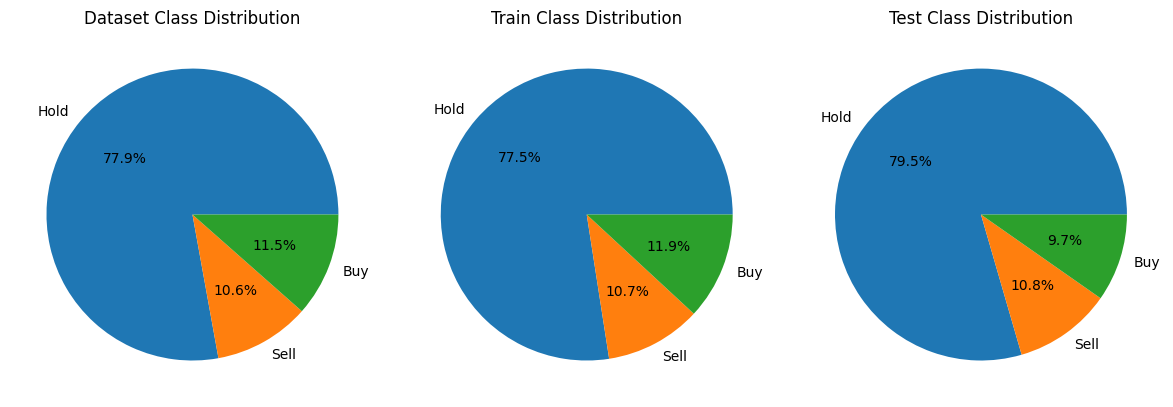

In [ ]:

# Create a figure and three subplots side by side
plt.figure(figsize=(12, 4))
labels = ["Hold","Sell", "Buy"]

plt.subplot(1, 3, 1)
plt.pie(class_counts.values(), labels=labels, autopct='%1.1f%%')
plt.title("Dataset Class Distribution")
# Plot the first pie chart on the left subplot
plt.subplot(1, 3, 2)
plt.pie(class_counts_train.values(), labels=labels, autopct='%1.1f%%')
plt.title("Train Class Distribution")

# Plot the second pie chart in the middle subplot
#plt.subplot(1, 4, 3)
#plt.pie(class_counts_val.values(), labels=labels, autopct='%1.1f%%')
#plt.title("Validation Class Distribution")

# Plot the third pie chart on the right subplot
plt.subplot(1, 3, 3)
plt.pie(class_counts_test.values(), labels=labels, autopct='%1.1f%%')
plt.title("Test Class Distribution")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
total = len(y_tr)
class_w = {
    0: total / (3 * np.sum(y_tr == 0)),
    1: total / (3 * np.sum(y_tr == 1)),
    2: total / (3 * np.sum(y_tr == 2))
}
print(class_w)


{0: 0.43034370551149076, 1: 3.1278640059127865, 2: 2.8045062955599733}


### Baseline LSTM

This is fold n 1
Train class distribution: [1086  147  179]
Validation class distribution: [1095  153  162]
Class weights {0: 0.43339472068753837, 1: 3.2560820938544905, 2: 2.629422718808194}


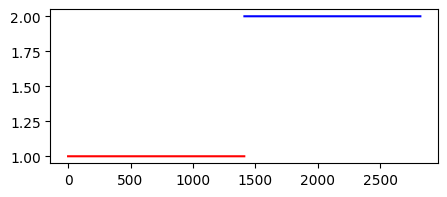

Epoch 1/10
45/45 [==============================] - 44s 325ms/step - loss: 1.1060 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.1059 - val_sparse_categorical_accuracy: 0.0986
Epoch 2/10
45/45 [==============================] - 11s 252ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.1197 - val_loss: 1.1029 - val_sparse_categorical_accuracy: 0.1113
Epoch 3/10
45/45 [==============================] - 13s 294ms/step - loss: 1.1051 - sparse_categorical_accuracy: 0.2585 - val_loss: 1.1182 - val_sparse_categorical_accuracy: 0.1248
Epoch 4/10
45/45 [==============================] - 10s 220ms/step - loss: 1.1051 - sparse_categorical_accuracy: 0.2684 - val_loss: 1.1119 - val_sparse_categorical_accuracy: 0.2447
Epoch 5/10
45/45 [==============================] - 11s 251ms/step - loss: 1.1033 - sparse_categorical_accuracy: 0.2642 - val_loss: 1.1172 - val_sparse_categorical_accuracy: 0.2475
Epoch 6/10
45/45 [==============================] - 12s 270ms/step - loss: 1.1025 - sparse_cate

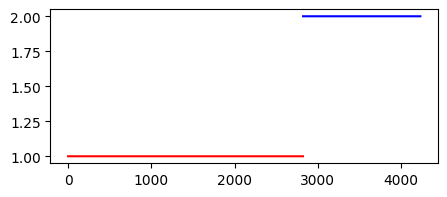

Epoch 1/10
89/89 [==============================] - 22s 245ms/step - loss: 1.1083 - sparse_categorical_accuracy: 0.3958 - val_loss: 1.0970 - val_sparse_categorical_accuracy: 0.4426
Epoch 2/10
89/89 [==============================] - 19s 213ms/step - loss: 1.1037 - sparse_categorical_accuracy: 0.4876 - val_loss: 1.1362 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/10
89/89 [==============================] - 19s 217ms/step - loss: 1.1024 - sparse_categorical_accuracy: 0.3639 - val_loss: 1.0949 - val_sparse_categorical_accuracy: 0.3730
Epoch 4/10
89/89 [==============================] - 22s 245ms/step - loss: 1.1013 - sparse_categorical_accuracy: 0.3894 - val_loss: 1.0940 - val_sparse_categorical_accuracy: 0.4383
Epoch 5/10
89/89 [==============================] - 19s 208ms/step - loss: 1.1043 - sparse_categorical_accuracy: 0.3714 - val_loss: 1.1165 - val_sparse_categorical_accuracy: 0.2723
Epoch 6/10
89/89 [==============================] - 19s 218ms/step - loss: 1.1005 - sparse_cate

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.0
num_layers= 8
l2_rate = 0.0
lr = 5e-4
opt = keras.optimizers.Adam(learning_rate= lr)
keras_lstm = create_keras_model(inp_size=inp_size, hidden_size=hidden_size, output_size=output_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
keras_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (2.95 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    keras_lstm.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
y_pred =  keras_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### AttentionLSTM

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LearningRateScheduler

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def step_decay(epoch):
    initial_lr = 5e-4  # Initial learning rate
    drop = 0.5         # Factor by which the learning rate will be reduced
    epochs_drop = 2    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)


This is fold n 1
Train class distribution: [1086  147  179]
Validation class distribution: [1095  153  162]
Class weights {0: 0.43339472068753837, 1: 3.201814058956916, 2: 2.629422718808194}


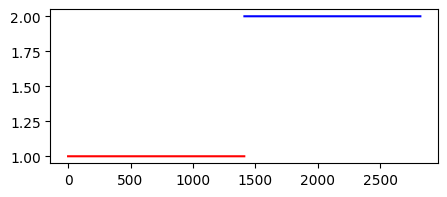

Epoch 1/10
45/45 [==============================] - 61s 582ms/step - loss: 1.1040 - sparse_categorical_accuracy: 0.2812 - val_loss: 1.0378 - val_sparse_categorical_accuracy: 0.7582 - lr: 5.0000e-04
Epoch 2/10
45/45 [==============================] - 20s 457ms/step - loss: 1.1006 - sparse_categorical_accuracy: 0.4497 - val_loss: 1.1129 - val_sparse_categorical_accuracy: 0.2638 - lr: 2.5000e-04
Epoch 3/10
45/45 [==============================] - 20s 451ms/step - loss: 1.0983 - sparse_categorical_accuracy: 0.3527 - val_loss: 1.0940 - val_sparse_categorical_accuracy: 0.4794 - lr: 2.5000e-04
Epoch 4/10
45/45 [==============================] - 19s 433ms/step - loss: 1.0970 - sparse_categorical_accuracy: 0.4207 - val_loss: 1.0955 - val_sparse_categorical_accuracy: 0.4362 - lr: 1.2500e-04
Epoch 5/10
45/45 [==============================] - 21s 468ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.1010 - val_sparse_categorical_accuracy: 0.3695 - lr: 1.2500e-04
Epoch 6/10

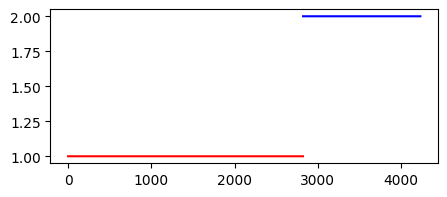

Epoch 1/10
89/89 [==============================] - 35s 393ms/step - loss: 1.1034 - sparse_categorical_accuracy: 0.3490 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.4950 - lr: 5.0000e-04
Epoch 2/10
89/89 [==============================] - 35s 398ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.4546 - val_loss: 1.0795 - val_sparse_categorical_accuracy: 0.5816 - lr: 2.5000e-04
Epoch 3/10
89/89 [==============================] - 35s 395ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.4224 - val_loss: 1.1095 - val_sparse_categorical_accuracy: 0.3475 - lr: 2.5000e-04
Epoch 4/10
89/89 [==============================] - 33s 376ms/step - loss: 1.0970 - sparse_categorical_accuracy: 0.3434 - val_loss: 1.0889 - val_sparse_categorical_accuracy: 0.4858 - lr: 1.2500e-04
Epoch 5/10
89/89 [==============================] - 35s 390ms/step - loss: 1.0962 - sparse_categorical_accuracy: 0.3930 - val_loss: 1.0877 - val_sparse_categorical_accuracy: 0.4553 - lr: 1.2500e-04
Epoch 6/10

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

# Define parameters
inp_size=X_tr.shape[-1]
hidden_size=64
output_size=3
dropout_rate=0.0
num_layers= 10
l2_rate = 0.0
lr = 5e-4
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1), lr_scheduler]

opt = keras.optimizers.Adam(learning_rate= lr)
att_lstm = build_attention_model(input_shape=X_tr.shape[1:], hidden_size=hidden_size, dropout_rate=dropout_rate, num_layers=num_layers,l2_rate = l2_rate)
att_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['sparse_categorical_accuracy'])
#callbacks = [EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1),lr_scheduler]
# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    att_lstm.fit(X_train, y_train,epochs=10, batch_size=32, callbacks = callbacks, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  att_lstm.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### Transformer

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LearningRateScheduler

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def step_decay(epoch):
    initial_lr = 1e-4  # Initial learning rate
    drop = 0.5         # Factor by which the learning rate will be reduced
    epochs_drop = 2    # Number of epochs after which to reduce the learning rate
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(step_decay)


This is fold n 1
Train class distribution: [1086  147  179]
Validation class distribution: [1095  153  162]
Class weights {0: 0.43339472068753837, 1: 3.201814058956916, 2: 2.629422718808194}


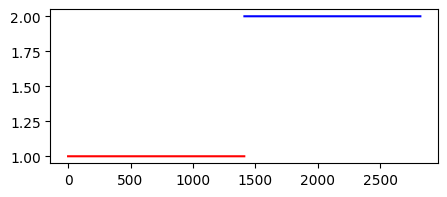

Epoch 1/10
45/45 [==============================] - 9s 62ms/step - loss: 1.2612 - sparse_categorical_accuracy: 0.5269 - val_loss: 0.9997 - val_sparse_categorical_accuracy: 0.5220 - lr: 1.0000e-04
Epoch 2/10
45/45 [==============================] - 2s 53ms/step - loss: 1.2209 - sparse_categorical_accuracy: 0.5120 - val_loss: 1.0113 - val_sparse_categorical_accuracy: 0.5135 - lr: 5.0000e-05
Epoch 3/10
45/45 [==============================] - 2s 48ms/step - loss: 1.2058 - sparse_categorical_accuracy: 0.4823 - val_loss: 1.0239 - val_sparse_categorical_accuracy: 0.4993 - lr: 5.0000e-05
Epoch 4/10
45/45 [==============================] - 2s 51ms/step - loss: 1.2030 - sparse_categorical_accuracy: 0.4915 - val_loss: 1.0294 - val_sparse_categorical_accuracy: 0.4915 - lr: 2.5000e-05
Epoch 5/10
45/45 [==============================] - 4s 91ms/step - loss: 1.2142 - sparse_categorical_accuracy: 0.4695 - val_loss: 1.0342 - val_sparse_categorical_accuracy: 0.4858 - lr: 2.5000e-05
Epoch 6/10
45/45 [==

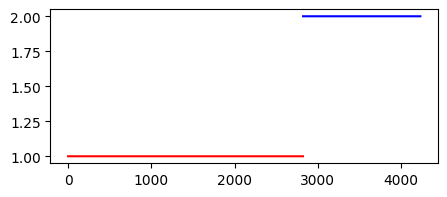

Epoch 1/10
89/89 [==============================] - 4s 47ms/step - loss: 1.1775 - sparse_categorical_accuracy: 0.4433 - val_loss: 1.0803 - val_sparse_categorical_accuracy: 0.4163 - lr: 1.0000e-04
Epoch 2/10
89/89 [==============================] - 4s 46ms/step - loss: 1.1653 - sparse_categorical_accuracy: 0.4227 - val_loss: 1.0888 - val_sparse_categorical_accuracy: 0.4028 - lr: 5.0000e-05
Epoch 3/10
89/89 [==============================] - 6s 62ms/step - loss: 1.1549 - sparse_categorical_accuracy: 0.4164 - val_loss: 1.0972 - val_sparse_categorical_accuracy: 0.3879 - lr: 5.0000e-05
Epoch 4/10
89/89 [==============================] - 5s 51ms/step - loss: 1.1495 - sparse_categorical_accuracy: 0.4075 - val_loss: 1.0982 - val_sparse_categorical_accuracy: 0.3865 - lr: 2.5000e-05
Epoch 5/10
89/89 [==============================] - 4s 43ms/step - loss: 1.1533 - sparse_categorical_accuracy: 0.4004 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.3801 - lr: 2.5000e-05
Epoch 6/10
89/89 [==

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1), lr_scheduler]

#opt = keras.optimizers.Adam(learning_rate= lr)
# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=4,
    num_heads=8,
    ff_dim=8,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.1,
    dropout=0.01,
l2_rate = 0.0)

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"])#keras.optimizers.Adam(learning_rate=lr)
# Train the model

# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    model_transformer.fit(X_train, y_train,epochs=10, batch_size=32,callbacks = callbacks, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


#### best

This is fold n 1
Train class distribution: [1086  147  179]
Validation class distribution: [1095  153  162]
Class weights {0: 0.43339472068753837, 1: 3.201814058956916, 2: 2.629422718808194}


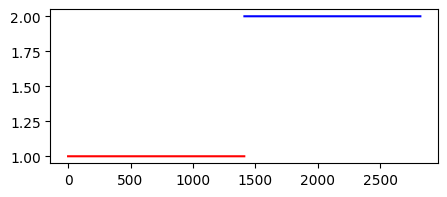

Epoch 1/10
45/45 [==============================] - 3s 28ms/step - loss: 1.2252 - sparse_categorical_accuracy: 0.2868 - val_loss: 1.1620 - val_sparse_categorical_accuracy: 0.3113
Epoch 2/10
45/45 [==============================] - 1s 24ms/step - loss: 1.1580 - sparse_categorical_accuracy: 0.3052 - val_loss: 1.1398 - val_sparse_categorical_accuracy: 0.3106
Epoch 3/10
45/45 [==============================] - 1s 23ms/step - loss: 1.1221 - sparse_categorical_accuracy: 0.3548 - val_loss: 1.1338 - val_sparse_categorical_accuracy: 0.3028
Epoch 4/10
45/45 [==============================] - 1s 27ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.3477 - val_loss: 1.1207 - val_sparse_categorical_accuracy: 0.3305
Epoch 5/10
45/45 [==============================] - 1s 30ms/step - loss: 1.0847 - sparse_categorical_accuracy: 0.3704 - val_loss: 1.1047 - val_sparse_categorical_accuracy: 0.3610
Epoch 6/10
45/45 [==============================] - 2s 38ms/step - loss: 1.0829 - sparse_categorical_accu

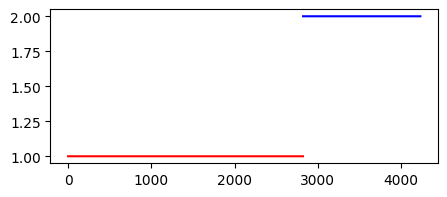

Epoch 1/10
89/89 [==============================] - 2s 19ms/step - loss: 1.0836 - sparse_categorical_accuracy: 0.3714 - val_loss: 1.0951 - val_sparse_categorical_accuracy: 0.3738
Epoch 2/10
89/89 [==============================] - 2s 18ms/step - loss: 1.0757 - sparse_categorical_accuracy: 0.3795 - val_loss: 1.0974 - val_sparse_categorical_accuracy: 0.3610
Epoch 3/10
89/89 [==============================] - 2s 19ms/step - loss: 1.0544 - sparse_categorical_accuracy: 0.3774 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.3589
Epoch 4/10
89/89 [==============================] - 2s 26ms/step - loss: 1.0429 - sparse_categorical_accuracy: 0.4018 - val_loss: 1.1076 - val_sparse_categorical_accuracy: 0.3362
Epoch 5/10
89/89 [==============================] - 2s 21ms/step - loss: 1.0315 - sparse_categorical_accuracy: 0.4057 - val_loss: 1.1089 - val_sparse_categorical_accuracy: 0.3426
Epoch 6/10
89/89 [==============================] - 2s 20ms/step - loss: 1.0238 - sparse_categorical_accu

In [ ]:
# Specify the number of folds
k = 2
# Create the cross-validation object

tscv = TimeSeriesSplit(n_splits=k)

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    EarlyStoppingByLossVal(monitor='val_loss', value=0.6, verbose=1), lr_scheduler]

opt = keras.optimizers.Adam(learning_rate= lr)
# Define the Transformer model
model_transformer = build_model(
    input_shape = X_tr.shape[1:],
    head_size=4,
    num_heads=8,
    ff_dim=8,
    num_transformer_blocks=1,
    mlp_units=[32],
    mlp_dropout=0.1,
    dropout=0.1,
l2_rate = 0.0)

model_transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"])#keras.optimizers.Adam(learning_rate=lr)
# Train the model

# Iterate over the folds
it = 1

for train_index, test_index in tscv.split(X_tr):
    print("This is fold n", it )
    # Split the data into training+validation and test sets for the current fold

    X_train, X_val = X_tr[train_index], X_tr[test_index]
    y_train, y_val = y_tr[train_index], y_tr[test_index]
    #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))

    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Fit the model
    model_transformer.fit(X_train, y_train,epochs=10, batch_size=32, validation_data=(X_val,y_val),  class_weight = class_w)

    it+=1
print("Now let's train it on the whole dataset")
#keras_lstm.fit(X_tr, y_tr,epochs=10, batch_size=64,  class_weight = class_w)
y_pred =  model_transformer.predict(X_te)
y_pred_labels = np.argmax(y_pred, axis=1)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred_labels, target_names=target_names,zero_division = 1))


### Random Forest Classifier

Train class distribution: [1086  147  179]
Validation class distribution: [1095  153  162]
Class weights {0: 0.43339472068753837, 1: 3.201814058956916, 2: 2.629422718808194}


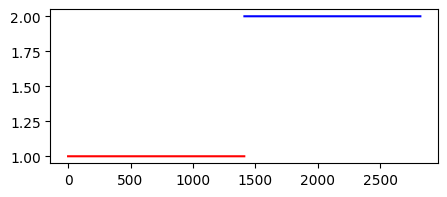

Train class distribution: [2181  300  341]
Validation class distribution: [1097  151  162]
Class weights {0: 0.43130062662387286, 1: 3.1355555555555554, 2: 2.758553274682307}


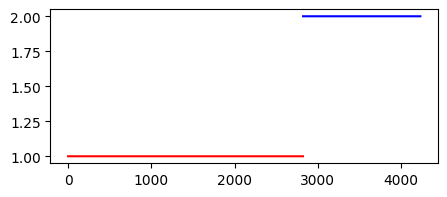

              precision    recall  f1-score   support

        Hold       0.81      0.49      0.61       818
        Sell       0.12      0.26      0.16       111
         Buy       0.10      0.28      0.15       100

    accuracy                           0.45      1029
   macro avg       0.34      0.34      0.31      1029
weighted avg       0.66      0.45      0.52      1029



In [ ]:
n_splits = 2
tscv = TimeSeriesSplit(n_splits=n_splits)
X_flattened = X_tr.reshape(X_tr.shape[0], -1)
X_te_flattened = X_te.reshape(X_te.shape[0], -1)

for train_index, test_index in tscv.split(X_flattened):
    X_train, X_test = X_flattened[train_index], X_flattened[test_index]
    y_train, y_test = y_tr[train_index], y_tr[test_index]
        #print("Train indices:", train_index, "Test indices:", test_index)
    print("Train class distribution:", np.bincount(y_tr[train_index]))
    print("Validation class distribution:", np.bincount(y_tr[test_index]))
    # calculate time-varying class distributions
    total = len(y_train)
    class_w = {
    0: total / (3 * np.sum(y_train == 0)),
    1: total / (3 * np.sum(y_train == 1)),
    2: total / (3 * np.sum(y_train == 2))}
    print("Class weights", class_w)
    plt.figure(figsize = (5,2))
    plt.plot(train_index, [1]*len(train_index), 'r')
    plt.plot(test_index, [2]*len(test_index), 'b')
    plt.show()
    # Train a Random Forest Classifier
    clf = RandomForestClassifier(n_estimators = 30, max_depth = 3, random_state=42,class_weight = class_w)
    clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_te_flattened)
target_names = ['Hold', 'Sell', 'Buy']
print(classification_report(y_te, y_pred, target_names=target_names,zero_division = 1))
